# **Аналитика ДТП**
Заказчиком выступает проект [«Карта ДТП»](https://dtp-stat.ru/) — некоммерческий проект, посвященный проблеме дорожно-транспортных происшествий в России.

## Часть 2. Исследование данных и проверка гипотез



<a id="#start"></a>
## 1 Постановка задачи и ход исследования

**Цель:**  

Провести глубокий анализ данных, сформулировать и проверить гипотезы, опираясь на доступные признаки.

**Описание задачи**:
- Провести исследовательский анализ данных о дорожно-транспортных происшествиях (ДТП).
- Сформулировать и проверить гипотезы, основываясь на имеющихся признаках.
- Построить дашборд используя любой удобный инструмент, с учетом того, что дашборд может быть опубликован

**В исследовании:**

В **Части 1** мы провели:
- Загрузку данных из предоставленных файлов
- Чтение и обработку данных в столбцах в форматах json и в списках
- Формирование новых датафреймов, содержащих:
  - данные о транспортных средствах, участвовавших в ДТП
  - о водителях, пассажирах и пешеходах, участвовавших в ДТП
- Обработку данных, изменение типов данных для уменьшения размера занимаемой оперативной памяти
- Формирование трех сводных датасетов, ообъединяющих в себе данные по всем регионам и соджержащие в себе:
  - данные о ДТП
  - данные о транспортных средствах, участвовавших в ДТП
  - о водителях, пассажирах и пешеходах, участвовавших в ДТП  
- Изучение общей информации о датафрейме
- Выгрузку на диск сводных датасетов в виде файлов формата .pickle

В **части 2** (в этой тетрадке) мы проведем:
- исследовательский анализ данных
- формирование и проверку гипотез:
  - В большинстве случаев виноваты пьяные водители, нужно усилить контроль
  - Безопасность на дорогах растет для каждого из участников
  - В личном автомобиле ехать безопаснее чем в автобусе
  - Если пешеходы не будут нарушать, то не будут гибнуть
  - Низкая скорость не влияет на тяжесть ДТП
- построение дашборда средствами DataLens

**Ход исследования:**
- Часть 2:
  - Исследовательский анализ данных
  - Проверка гипотез
  - Построение дашборда
  - Выводы и заключения

<a id="library"></a>
## 2 Импорт библиотек и создание функций


### 2.1. Установка дистрибутивов

In [ ]:
pip install dill --quiet

### 2.2. Установка библиотек




In [ ]:
# для извлечения и анализа данных
import pandas as pd
import os
import re
import requests
from tqdm import tqdm
from google.colab import drive
drive.mount('/content/drive')
import warnings
import time # для расчета времени обработки ноутбука
import logging
import dill as pickle # для сериализации объектов и сохранения данных в формате .pickle
import json
import matplotlib.pyplot as plt

import datetime as dt
import math as mth
import numpy as np
from scipy import stats as st
from scipy.stats import spearmanr, pearsonr
from statistics import variance

# настройка отображения
pd.options.display.max_columns = 30

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Перейдем в рабочую папку
os.chdir('/content/drive/MyDrive/Мастерская_Аналитика_ДТП')

### 2.3. Создание функций




In [ ]:
# Подготовка данных и проведение статистических тестов

def prepear_test(df_0, df_1, param, title_0, title_1, option, choice = 'greater'):
  dead_0 = len(df_0[df_0[param] != 0][param])
  alive_0 = len(df_0[df_0[param] == 0][param])
  dead_1 = len(df_1[df_1[param] != 0][param])
  alive_1 = len(df_1[df_1[param] == 0][param])

  print(f'{title_0}\n\
    всего ДТП - {len(df_0)}\n\
    ДТП с {param} - {dead_0}\n\
    ДТП без {param}  - {alive_0}\n\
    Процент ДТП с {param} {dead_0/len(df_0):.2%}')

  print(f'{title_1}\n\
    всего ДТП - {len(df_1)}\n\
    ДТП с {param} - {dead_1}\n\
    ДТП без {param}  - {alive_1}\n\
    Процент ДТП с {param} {dead_1/len(df_1):.2%}')

# Посчитаем статистику
  alpha = .05 # критический уровень статистической значимости

  dead = np.array([dead_0, dead_1])
  all_part = np.array([len(df_0),len(df_1)])
  #print(dead, all_part)
  print(20*'-')
  print('Посчитаем статистику, проведем z-test')
  # вызовем функцию
  z_test(dead, all_part, alpha, option, param)

  # Проведем t-test
  print(20*'-')
  print('Проведем t-test')
  p_value = st.ttest_ind(df_0[param],
                       df_1[param],
                       equal_var=False,
                       alternative= choice)[1]

  print('p-значение: ', p_value)

  if p_value > alpha:
    print(f'Не удалось отвергнуть нулевую гипотезу.  Для {param} среднее значение распределения {title_0} не выше, чем {title_1}')
  else:
    print(f'Нулевая гипотеза отвергнута.  Для {param} среднее значение распределения {title_0} выше, чем {title_1}')


  return#(dead_0, alive_0, dead_1, alive_1)

In [ ]:
# Расчет z-теста
def z_test(successes, trials, alpha, option, param):


    alpha = alpha
    successes = successes
    trials = trials

    # пропорция успехов в первой группе:
    p1 = successes[0] / trials[0]

    # пропорция успехов во второй группе:
    p2 = successes[1] / trials[1]

    # пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

    # разница пропорций в датасетах
    difference = p1 - p2

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) *
                                    (1 / trials[0] + 1 / trials[1]))



    print(f'\n\
          пропорция успехов в первой группе p1 =  {p1} \n\
          пропорция успехов во второй группе p2 = {p2}\n\
          пропорция успехов в комбинированном датасете p_combined = {p_combined}\n\
          разница пропорций в датасетах difference =  {difference}\n\
          z_value {z_value}')

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)

    p_value = (1 - distr.cdf(abs(z_value))) # гипотеза односторонняя поэтому без 2

    print('p-значение: ', p_value)

    if p_value < alpha:
        print(f'Отвергаем нулевую гипотезу: доля c {param} {option} больше, есть значимая разница')
    else:
        print(
            f'Не получилось отвергнуть нулевую гипотезу, доля с [param] {option} не больше'
        )




In [ ]:
# Для создания новых столбцов в датафрейме
def insert_column(df_name, col_name):
  df_name.insert (loc= len(df_name.columns) , column=col_name, value = 0)
  return

In [ ]:
# Для построения столбчатой диаграммы
def event_in_time_bar(data_name, eventname, time_interval, operation, ax, x_rotation = 0):
    t1 = data_name.groupby(time_interval).agg({eventname:operation})#.sort_values(time_interval)

    ax = t1.plot(figsize=(15,5),
    kind ='bar',
    y = eventname,
    linewidth=5,
    alpha=0.7,
    label='Временной отрезок: '+ time_interval,
                 color = 'blue',
    ax=ax
    )

    plt.title('Количество событий {} \nв зависимости от времени {}\n'.format(eventname, time_interval), fontsize=12, color = "b")
    plt.legend(fontsize=10,  loc='upper right' ) # ,bbox_to_anchor=(0.8, 1))
    plt.xticks(rotation=x_rotation, fontsize=10, color = "b")
    plt.yticks(rotation=0, fontsize=10, color = "b")
    plt.xlabel(f'{time_interval}', fontsize=16, color = "b")
    plt.ylabel(f"Количество событий {eventname}", fontsize=10, color = "b")

    return

In [ ]:
# Для отображения двух графиков на одном поле
def dist_in_time(df, value, step):
# задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

# в первой ячейке строим распределение по группе количеству заказов
    ax1 = plt.subplot(1, 2, 1)
# вызываем функцию
    event_in_time_bar(df, 'share_of_dead', value, step, ax1)

# во второй ячейке строим распределение по количеству покупателей
    ax2 = plt.subplot(1, 2, 2)
# вызываем функцию
    event_in_time_bar(df, 'share_of_injured', value, step, ax2)

    return

In [ ]:
# Для отображения трех графиков на одном поле
def dist_in_time_3(df, value, step, x_rotation=0):
# задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

# строим график в первой ячейке
    ax1 = plt.subplot(1, 3, 1)
# вызываем функцию
    event_in_time_bar(df, 'accident_count', value, step, ax1, x_rotation)

# строим график во второй ячейке
    ax2 = plt.subplot(1, 3, 2)
# вызываем функцию
    event_in_time_bar(df, 'dead_count', value, step, ax2, x_rotation)

# строим график в третьей ячейке
    ax3 = plt.subplot(1, 3, 3)
# вызываем функцию
    event_in_time_bar(df, 'injured_count', value, step, ax3, x_rotation)


    return

# 3 Проверка гипотез

Итак, мы хотим проверить предположения:
* Всему виной пьяные водители, надо усилить наказание.
* Безопасность на дорогах растет для каждого из участников.
* В личном автомобиле ехать безопаснее чем в автобусе.
* Если пешеходы не будут нарушать, то не будут гибнуть.
* Низкая скорость не влияет на тяжесть ДТП.

Есть два варианта анализа. Первый - графический. По графикам в Части 1 можно сказать, что пострадавших меньше и вроде бы безопасность растет.
Здесь можно более детально проанализировать количество ДТП по годам и их характер.

Вторым моментом можно провести статистические тесты. Для примера возьмем два теста t-test, z-критерий. Для их работы нужно выполнить два условия:

- должны быть сформулированы гипотезы.
- определены выборки по критериям.
- выборки должны быть представлены числовыми рядами.

После этого мы проверим гипотезы и сделаем выводы по предположениям.


## 3.1. В большинстве случаев виноваты пьяные водители, нужно усилить контроль


Возьмем первое предположение:

Всему виной пьяные водители, надо усилить наказание.
В таком виде предположение нас не устраивает: нужно понять на сколько опаснее ДТП с пьяными водителями. То есть в этих ДТП должно быть больше раненных и погибших, чем в остальных.
Таким образом нам нужно посчитать количество пострадавших или погибших.
Погибшие - люди, получившие крайнюю степень повреждения.
Поэтому формулируем гипотезу по погибшим.

В ДТП с пьяными водителями погибает больше людей, чем в остальных с участием водителей

Таким образом мы будем использовать односторонний тест.

Формулируем гипотезы для t-test:
- Нулевая гипотеза Н0: В ДТП с участием пьяных водителей гибнет не больше, чем у трезвых.
- Альтернативная гипотеза Н1: В ДТП с участием пьяных водителей людей гибнет больше, чем у при ДТП с трезвыми водителями.

Формулируем гипотезы для z-критерия:
- Нулевая гипотеза Н0: доля пьяных ДТП с погибшими не превышает долю трезвых ДТП с погибшими, различия статистически незначимы.
- Альтернативная гипотеза Н1: Доля пьяных ДТП с погибшими выше доли трезвых ДТП с погибшими, различия статистически значимы.

Какую задачу мы должны решить.
- Сформировать выборки.
    - Выделить всех водителей.
    - Определить, кто из них был пьян во время ДТП.
    - Выделить ДТП с участием пьяных водителей.
    - Выделить ДТП с участием только трезвых водителей.
- Сравнить выборки тестом.

### Загрузим созданный в Части 1 датасет с пешеходами, водителями и пассажирами.


In [ ]:
with open("data_foot_part.pickle", 'rb') as file:
    data_foot_part = pickle.load(file)

In [ ]:
data_foot_part.head()

,id,role,gender,violations,health_status,years_of_driving_experience
0,2525237,Водитель,Мужской,[],Не пострадал,35.0
1,2060303,Пассажир,Женский,[],Не пострадал,Не заполнено
2,2060303,Пассажир,Не заполнено,[],Скончался на месте ДТП до приезда скорой медиц...,Не заполнено
3,2060303,Пассажир,Мужской,[],Не пострадал,Не заполнено
4,2060303,Водитель,Мужской,[Нарушение правил расположения ТС на проезжей ...,Не пострадал,9.0


In [ ]:
# имеющиеся категории людей - участников ДТП
data_foot_part['role'].unique().tolist()

['Водитель',
 'Пассажир',
 'Велосипедист',
 'Пешеход, перед ДТП находившийся в (на) ТС в качестве водителя или пешеход, перед ДТП находившийся в (на) ТС в качестве пассажира',
 'Пешеход']

Выделим только водителей.

In [ ]:
# Выделим только водителей.
df_drivers = data_foot_part[data_foot_part['role'] == 'Водитель'].reset_index(drop = True).copy()

Теперь нам надо получить тех, кто злоупотребил. Смотрим "вину".  
Выведем на экран перечень присутствующих нарушений

In [ ]:
df_drivers['violations'].explode().unique()

array([nan, 'Нарушение правил расположения ТС на проезжей части',
       'Управление ТС в состоянии алкогольного опьянения',
       'Неправильный выбор дистанции',
       'Нарушение режима труда и отдыха водителя',
       'Несоответствие скорости конкретным условиям движения',
       'Отказ водителя от прохождения медицинского освидетельствования на состояние опьянения',
       'Другие нарушения ПДД водителем',
       'Употребление водителем алкогольных напитков, наркотических, психотропных или иных одурманивающих веществ после дорожно-транспортного происшествия, к которому он причастен, до проведения освидетельствования с целью установления состояния опьянения или до принятия решения об освобождении от проведения такого освидетельствовани',
       'Выезд на полосу встречного движения',
       'Несоблюдение очередности проезда',
       'Несоблюдение условий, разрешающих движение транспорта задним ходом',
       'Управление ТС лицом, не имеющим права на управление ТС',
       'Оставлени

Все интересующие нас нарушения содержат слово "опьянения". Сюда будут входить и состояния наркотического опьянения.

Для получения данных разметим датасет на "пьян" - 0 и "трезв" -1.

Пишем функцию.



In [ ]:
def drunk_sober_drivers(row):
    row_list = row['violations']
    if len(row_list) != 0:
        for violation in row_list:
            if 'опьянения' in violation:
                return 0
    return 1

In [ ]:
df_drivers['drunk_sober'] = df_drivers.apply(drunk_sober_drivers, axis = 1)

Теперь нам нужно оставить только 'id', 'drunk_sober'.

In [ ]:
df_drivers = df_drivers[['id','drunk_sober']]

Удалим дубликаты.

In [ ]:
df_drivers = df_drivers.drop_duplicates().reset_index(drop=True)

In [ ]:
df_drivers.sort_values('id').head()

,id,drunk_sober
513596,1527476,1
538851,1527477,1
513595,1527478,1
473130,1527479,1
497891,1527480,1


In [ ]:
df_drivers.drunk_sober.value_counts()

1    1299092
0     172421
Name: drunk_sober, dtype: int64

У нас остались ситуации, когда в ДТП участвуют  трезвые и пьяные водители, в этом случае у нас ДТП с участием пьяного водителя. Поэтому этим индексам присваиваем статус "пьян". И снова удалим дубликаты.

In [ ]:
df_drivers.loc[df_drivers['id'].duplicated(), 'drunk_sober'] = 0

In [ ]:
df_drivers = df_drivers.drop_duplicates(subset = 'id').reset_index(drop=True)

In [ ]:
df_drivers['drunk_sober'].value_counts()

1    1254462
0     143439
Name: drunk_sober, dtype: int64

Количество пьяных и трезвых ДТП сократилось.

In [ ]:
df_drivers['drunk_sober'] = df_drivers['drunk_sober'].astype('int8')

In [ ]:
df_drivers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1397901 entries, 0 to 1397900
Data columns (total 2 columns):
 #   Column       Non-Null Count    Dtype
---  ------       --------------    -----
 0   id           1397901 non-null  int32
 1   drunk_sober  1397901 non-null  int8 
dtypes: int32(1), int8(1)
memory usage: 6.7 MB


#### Из основного датасета присоединим погибших.   
Загрузим столбцы id и число погибших.

In [ ]:
# Загрузим основную базу
# Нам достаточно для исследования только данных по погибшим  и по пострадавшим
with open("data_base.pickle", 'rb') as file:
    data_base = pickle.load(file)[['id', 'injured_count','dead_count']]

In [ ]:
#with open("data_foot_part.pickle", 'rb') as file:
#    data_foot_part = pickle.load(file)

In [ ]:
#data_foot_part.head(50)

In [ ]:
#data_foot_part.role.unique()

In [ ]:
# Объединяем датасеты.

df_drivers = df_drivers.merge(data_base, on = 'id', how = 'left')

In [ ]:
# В разрезе пьяных и трезвых ДТП посмотим общее количество происшествий
# и происшествий со смертельным исходом: максимальное, среднее и общее количество погибших
#
df_drivers.groupby('drunk_sober')['dead_count'].agg(['count','max','mean','sum'])

,count,max,mean,sum
drunk_sober,,,,
0,143439,8,0.227693,32660
1,1254462,20,0.099887,125304


In [ ]:
df_drivers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1397901 entries, 0 to 1397900
Data columns (total 4 columns):
 #   Column         Non-Null Count    Dtype
---  ------         --------------    -----
 0   id             1397901 non-null  int32
 1   drunk_sober    1397901 non-null  int8 
 2   injured_count  1397901 non-null  int8 
 3   dead_count     1397901 non-null  int8 
dtypes: int32(1), int8(3)
memory usage: 20.0 MB


Примерно 9-ая часть - ДТП с нетрезвым водителем, при этом количество погибших составляют примерно 5-ую часть.

In [ ]:
# Посмотрим распределение
df_drivers.describe().round(3)

,id,drunk_sober,injured_count,dead_count
count,1397901.000,1397901.000,1397901.000,1397901.000
mean,2235747.068,0.897,1.269,0.113
std,409415.519,0.303,0.902,0.389
min,1527476.000,0.000,0.000,0.000
25%,1880570.000,1.000,1.000,0.000
50%,2235614.000,1.000,1.000,0.000
75%,2588993.000,1.000,1.000,0.000
max,2949081.000,1.000,57.000,20.000


Из описательных статистик видно, что максимальное число погибших составляет 20 человек.

In [ ]:
# Посмотрим связь между числом погибших и состоянием водителей.
# Для непараметрического ряда рассчиаем ранговую корреляцию Спирмена
df_drivers[['drunk_sober','dead_count']].corr(method= 'spearman')

,drunk_sober,dead_count
drunk_sober,1.000000,-0.110771
dead_count,-0.110771,1.000000


Чтобы проверить, является ли эта корреляция статистически значимой, мы можем рассчитать p-значение, связанное с коэффициентом корреляции Спирмена, с помощью Scipy spearmanr(), которая возвращает коэффициент корреляции Спирмена вместе с двусторонним p-значением.

In [ ]:
spearmanr(df_drivers[['drunk_sober','dead_count']])

SignificanceResult(statistic=-0.11077110160820611, pvalue=0.0)

Коэффициент корреляции равен –0.111, а двустороннее значение p = 0.0. Поскольку это значение p меньше общепринятого значения уровня статистической значимости 0.05, то мы можем заключить, что существует статистически значимая корреляция между двумя переменными.

Мы видим слабую отрицательную статистически значимую связь. Возможно сушествуют еще другие признаки.

### Проведем статистический тест

Создадим датасеты (выборки) с трезвыми и пьяными водителями.

In [ ]:
df_drunk = df_drivers[df_drivers['drunk_sober'] == 0]

In [ ]:
df_sober = df_drivers[df_drivers['drunk_sober'] == 1]

И посмотрим соотношение между погибшими в ДТП у пьяных и трезвых водителей внутри каждой группы.

In [ ]:
dead_drunk = len(df_drunk[df_drunk['dead_count'] != 0]['dead_count'])
alive_drunk = len(df_drunk[df_drunk['dead_count'] == 0]['dead_count'])
dead_sober = len(df_sober[df_sober['dead_count'] != 0]['dead_count'])
alive_sober = len(df_sober[df_sober['dead_count'] == 0]['dead_count'])

Посмотрим долю ДТП с погибшими.

In [ ]:
print(f'Пьяная травма\n\
    всего ДТП - {len(df_drunk)}\n\
    ДТП с погибшими - {dead_drunk}\n\
    ДТП без погибших  - {alive_drunk}\n\
    Процент ДТП с погибшими {dead_drunk/len(df_drunk):.2%}')

Пьяная травма
    всего ДТП - 143439
    ДТП с погибшими - 27572
    ДТП без погибших  - 115867
    Процент ДТП с погибшими 19.22%


In [ ]:
print(f'Трезвая травма\n\
    всего ДТП - {len(df_sober)}\n\
    ДТП с погибшими - {dead_sober}\n\
    ДТП без погибших  - {alive_sober}\n\
    Процент ДТП с погибшими {dead_sober/len(df_sober):.2%}')

Трезвая травма
    всего ДТП - 1254462
    ДТП с погибшими - 106523
    ДТП без погибших  - 1147939
    Процент ДТП с погибшими 8.49%


То есть вновь мы видим, что ДТП с пьяными водителями приводят к более опасным последствиям - доля погибших в таких ДТП вдвое превышает долю погибших в ДТП, где водители были трезвыми.

Посчитаем статистики.

In [ ]:
alpha = .05 # критический уровень статистической значимости

dead = np.array([dead_drunk, dead_sober])
all_part = np.array([len(df_drunk),len(df_sober)])


In [ ]:
# проведем z - тест
z_test(dead, all_part, alpha, "в пьяном ДТП", 'dead_count')


          пропорция успехов в первой группе p1 =  0.19222108352679537 
          пропорция успехов во второй группе p2 = 0.08491528639368909
          пропорция успехов в комбинированном датасете p_combined = 0.09592596328352294
          разница пропорций в датасетах difference =  0.10730579713310628
          z_value 130.73060580054135
p-значение:  0.0
Отвергаем нулевую гипотезу: доля c dead_count в пьяном ДТП больше, есть значимая разница


Проверим t-test

In [ ]:
p_value = st.ttest_ind(df_drunk['dead_count'],
                       df_sober['dead_count'],
                       equal_var=False,
                       alternative='greater')#[1]

print('p-значение: ', p_value)

if p_value[1] > alpha:
    print('Не удалось отвергнуть нулевую гипотезу. Принимаем нулевую гипотезу: В ДТП с участием пьяных водителей гибнет не больше, чем у трезвых.')
else:
    print('Нулевая гипотеза отвергнута. Принимаем альтернативную гипотезу: В ДТП с участием пьяных водителей людей гибнет больше, чем у при ДТП с трезвыми водителями.')

p-значение:  TtestResult(statistic=90.27792359869778, pvalue=0.0, df=160230.7533760258)
Нулевая гипотеза отвергнута. Принимаем альтернативную гипотезу: В ДТП с участием пьяных водителей людей гибнет больше, чем у при ДТП с трезвыми водителями.


Для удобства дальнейших расчетов мы интегрировали код для расчтета z- и t- критериев в одну функцию: `prepear_test`   
Применим функцию `prepear_test` и **повторим расчет с погибшими**

In [ ]:
prepear_test(df_drunk, df_sober, 'dead_count', 'Пьяный', 'Трезвый', "в пьяном ДТП")

Пьяный
    всего ДТП - 143439
    ДТП с dead_count - 27572
    ДТП без dead_count  - 115867
    Процент ДТП с dead_count 19.22%
Трезвый
    всего ДТП - 1254462
    ДТП с dead_count - 106523
    ДТП без dead_count  - 1147939
    Процент ДТП с dead_count 8.49%
--------------------
Посчитаем статистику, проведем z-test

          пропорция успехов в первой группе p1 =  0.19222108352679537 
          пропорция успехов во второй группе p2 = 0.08491528639368909
          пропорция успехов в комбинированном датасете p_combined = 0.09592596328352294
          разница пропорций в датасетах difference =  0.10730579713310628
          z_value 130.73060580054135
p-значение:  0.0
Отвергаем нулевую гипотезу: доля c dead_count в пьяном ДТП больше, есть значимая разница
--------------------
Проведем t-test
p-значение:  0.0
Нулевая гипотеза отвергнута.  Для dead_count среднее значение распределения Пьяный выше, чем Трезвый


Проведем сравнения с **пострадавшими**

In [ ]:
prepear_test(df_drunk, df_sober, 'injured_count', 'Пьяный', 'Трезвый', "в пьяном ДТП")

Пьяный
    всего ДТП - 143439
    ДТП с injured_count - 127603
    ДТП без injured_count  - 15836
    Процент ДТП с injured_count 88.96%
Трезвый
    всего ДТП - 1254462
    ДТП с injured_count - 1186445
    ДТП без injured_count  - 68017
    Процент ДТП с injured_count 94.58%
--------------------
Посчитаем статистику, проведем z-test

          пропорция успехов в первой группе p1 =  0.8895976686954036 
          пропорция успехов во второй группе p2 = 0.945779943912211
          пропорция успехов в комбинированном датасете p_combined = 0.9400150654445486
          разница пропорций в датасетах difference =  -0.05618227521680741
          z_value -84.88578963297813
p-значение:  0.0
Отвергаем нулевую гипотезу: доля c injured_count в пьяном ДТП больше, есть значимая разница
--------------------
Проведем t-test
p-значение:  3.131820156062332e-45
Нулевая гипотеза отвергнута.  Для injured_count среднее значение распределения Пьяный выше, чем Трезвый


Таким образом, можно утверждать, что вождение в нетрезвом виде представляет опасность в случае ДТП, однако  между числом погибших и пьяным вождением наблюдается слабая связь, что указывает на наличие других факторов влияющих на количество погибших.

## 3.2. Безопасность на дорогах растет для каждого из участников.

Посмотрим среднемесячные цифры - смертность и травматизм для всех участников движения в совокупности.

Сравним между собой три последних года к трем предшествующим




### Загрузим  файл `data_base` и обработаем данные из него   



In [ ]:
with open("data_base.pickle", 'rb') as file:
    data_base = pickle.load(file)

In [ ]:
# В датафрейме присутствует столбец severity - оценивающий тяжесть ДТП. Посмотрим, можем ли мы на эти данные опереться
data_base.severity.unique()

['Легкий', 'С погибшими', 'Тяжёлый']
Categories (3, object): ['Легкий', 'С погибшими', 'Тяжёлый']

В датафрейме присутствует столбец severity - оценивающий тяжесть ДТП. Но критерии 'Легкий' и 'Тяжёлый' расплывчатые. Воспользуемся источником с цифрами - это столбцы с количеством погибших и раненых -  dead_count и 	injured_count.  
И, конечно, гам понадобятся столбцы с id для подсчета и с датой происшествия.  
Избавимся от остальныз столбцов.

In [ ]:
# Сохраним данные в новом файле.
# Сохраним в датафрейме только требуемые для исследования столбцы
# Удалим загрузку
data_date = data_base[['id', 'datetime', 'dead_count',	'injured_count']].copy().reset_index(drop = True)

In [ ]:
del data_base

In [ ]:
# проверим на пропущенные значения
data_date.notna().mean()

id               1.0
datetime         1.0
dead_count       1.0
injured_count    1.0
dtype: float64

In [ ]:
# Визуально проверим несколько дубликатов по ID
try:
  for i in data_date.loc[data_date['id'].duplicated(), 'id'].sample(10).tolist():
    display(data_date.query('id ==@i'))

except:
  print('Дубликаты отсутствуют')

Дубликаты отсутствуют


In [ ]:
#Выделим из даты год и месяц
# Создадим столбцы
for i in ['year', 'month']:
  insert_column(data_date, i)

data_date.year = data_date.datetime.dt.year.astype('int16')
data_date.month = data_date.datetime.dt.month.astype('int8')

In [ ]:
data_date.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1411646 entries, 0 to 1411645
Data columns (total 6 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   id             1411646 non-null  int32         
 1   datetime       1411646 non-null  datetime64[ns]
 2   dead_count     1411646 non-null  int8          
 3   injured_count  1411646 non-null  int8          
 4   year           1411646 non-null  int16         
 5   month          1411646 non-null  int8          
dtypes: datetime64[ns](1), int16(1), int32(1), int8(3)
memory usage: 22.9 MB


In [ ]:
# сгруппируем по году и месяцу. Посчитаем количество событий и сумму по полям погибших и травмированных
data_date_grupped = data_date.groupby(['year', 'month']).\
    agg({'id':'count', 'dead_count':'sum', 'injured_count':'sum'}).reset_index()

In [ ]:
#  переименуеи столбец id, назовем его accident_count
data_date_grupped = data_date_grupped.rename(columns = {'id':'accident_count'})


### Рассмотрим изменение безопасности
Рассмотрим изменение безопасности как:
- изменение среднемесячного количества происшествий / гибели людей / травмирования людей в разрезе годов за весь период наблюдения
- изменение относительных показателей - доли количества смертей и доли количества травм к количеству ДТП. Эти пераметры также рассмотрим как среднегодовые

In [ ]:
# Произведем еще одные группировку по году и рассчитаем среднемесячные показатели количества происшествий, смертей и травм
data_date_grupped_year = data_date_grupped.groupby('year').agg({'accident_count':'mean', 'dead_count':'mean', 'injured_count':'mean'}).reset_index()

Мы подготовили датафрейм содержащий данные в разрезе годов о:
- Количестве ДТП
- Количестве погибщих людей в ДТП
- Количестве травмированных и раненых людей в ДТП


Поскольку мы имеем дело с непрерывным рядом данных, для выявления зависимостей  воспользуемся методом Пирсона

#### Найдем зависимость между годом и количеством происшествий / гибели людей / травмирования людей

In [ ]:
# Посмотрим связь между годом и количества происшествий / гибели людей / травмированию людей
# Для параметрического ряда рассчиаем ранговую корреляцию Пирсона
for i in data_date_grupped_year.columns[1:]:
  print('Для показателя ', i)
  display(data_date_grupped_year[['year', i]].corr())
  print('-'*40)

Для показателя  accident_count


,year,accident_count
year,1.000000,-0.946777
accident_count,-0.946777,1.000000


----------------------------------------
Для показателя  dead_count


,year,dead_count
year,1.000000,-0.974717
dead_count,-0.974717,1.000000


----------------------------------------
Для показателя  injured_count


,year,injured_count
year,1.000000,-0.949678
injured_count,-0.949678,1.000000


----------------------------------------


In [ ]:
data_date_grupped_year.corr()

,year,accident_count,dead_count,injured_count
year,1.000000,-0.946777,-0.974717,-0.949678
accident_count,-0.946777,1.000000,0.962793,0.998643
dead_count,-0.974717,0.962793,1.000000,0.955882
injured_count,-0.949678,0.998643,0.955882,1.000000


По шкале [Чеддока](https://statpsy.ru/correlation/velicina/) мы видим очень выкокую положительныю корреляцию

Чтобы проверить, является ли эта корреляция статистически значимой, мы можем рассчитать p-значение, связанное с коэффициентом корреляции Пирсона, с помощью Scipy pearsonr(), которая возвращает коэффициент корреляции Пирсона вместе с двусторонним p-значением.

In [ ]:
# Посмотрим связь между годом и количества происшествий / гибели людей / травмированию людей
# Для параметрического ряда рассчиаем ранговую корреляцию Пирсона
for i in data_date_grupped_year.columns[1:]:
  print('Для показателя ', i)
  display(pearsonr(data_date_grupped_year['year'], data_date_grupped_year[i]))
  print('-'*40)



Для показателя  accident_count


PearsonRResult(statistic=-0.9467774139669889, pvalue=3.291175458413205e-05)

----------------------------------------
Для показателя  dead_count


PearsonRResult(statistic=-0.9747166660310359, pvalue=1.7341134891049586e-06)

----------------------------------------
Для показателя  injured_count


PearsonRResult(statistic=-0.9496782990064769, pvalue=2.6395469337462768e-05)

----------------------------------------


Коэффициент корреляции для всех трех показателей превышает 0,9, а двустороннее значение p = стремится к нулю. Поскольку это значение p меньше общепринятого значения уровня статистической значимости 0.05, то мы можем заключить, что существует статистически значимая корреляция между переменными. Зависимость очень сильная и отрицательная, с течением времени снижается количество ДТП, количество погибших и количество пострадавших в ДТП.  
Интересно увидеть и сильную прямую зависимость между количеством ДТП и количеством погибших и пострадавших людей.

Проиллюстрируем сказанное несколькими диаграммами и увидим, что:
- в разрезе годов динамика количества погибнувших имеет отличия от динамики количества происшествий и динамики пострадавших
- в разрезе сезонности в сентябре-декабре  изменение параметров несколько различается

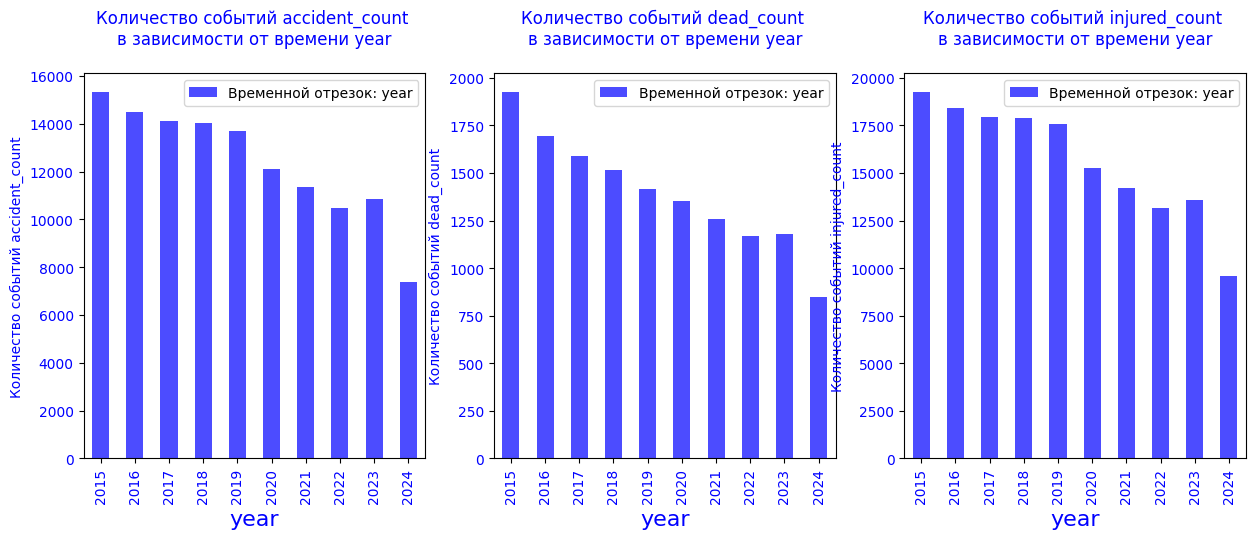

In [ ]:
dist_in_time_3(data_date_grupped, 'year', 'mean', 90)

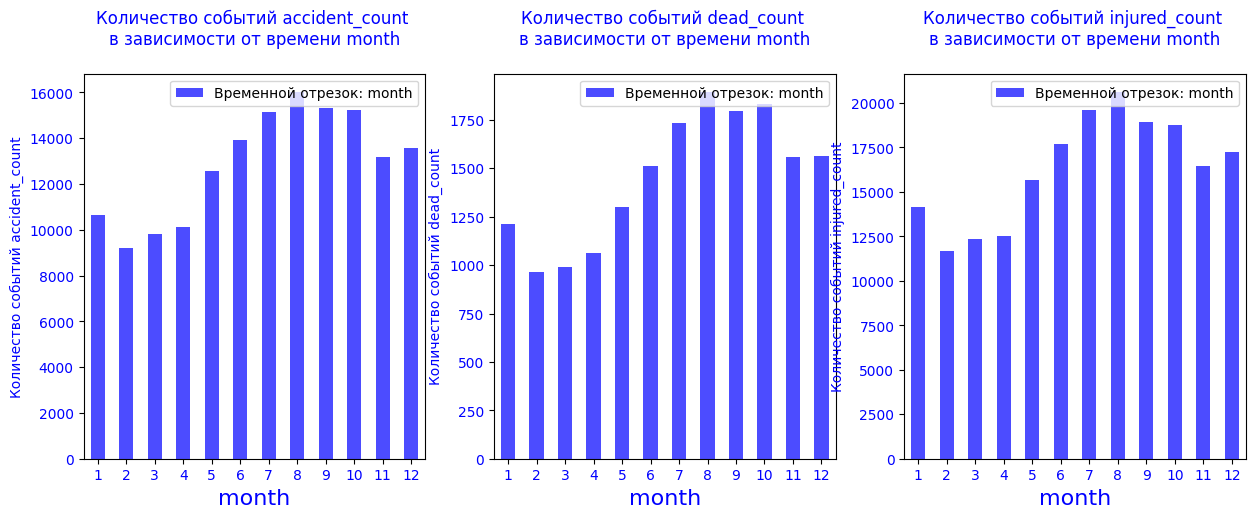

In [ ]:
dist_in_time_3(data_date_grupped, 'month', 'mean')

#### Найдем зависимость между годом и долей количества смертей / долей количества травм к количеству ДТП.

In [ ]:
#  в датафрейм data_date_grupped_year добавим столбцы, в которых рассчитаем доли погибших и пострадавших
data_date_grupped_year['share_of_dead'] = round(data_date_grupped_year['dead_count'] / data_date_grupped_year['accident_count']*100 , 2)
data_date_grupped_year['share_of_injured'] = round(data_date_grupped_year['injured_count'] / data_date_grupped_year['accident_count']*100 , 2)

In [ ]:
# Посмотрим связь между годом и Долей количества погибшихи людей / травмированых людей к количеству происшествий
# Для параметрического ряда рассчиаем ранговую корреляцию Пирсона
for i in data_date_grupped_year.columns[-2:]:
  print('Для показателя ', i)
  display(data_date_grupped_year[['year', i]].corr())
  print('-'*40)

Для показателя  share_of_dead


,year,share_of_dead
year,1.000000,-0.450619
share_of_dead,-0.450619,1.000000


----------------------------------------
Для показателя  share_of_injured


,year,share_of_injured
year,1.000000,0.023744
share_of_injured,0.023744,1.000000


----------------------------------------


In [ ]:
data_date_grupped_year.corr().round(3)

,year,accident_count,dead_count,injured_count,share_of_dead,share_of_injured
year,1.000,-0.947,-0.975,-0.950,-0.451,0.024
accident_count,-0.947,1.000,0.963,0.999,0.217,-0.162
dead_count,-0.975,0.963,1.000,0.956,0.472,-0.213
injured_count,-0.950,0.999,0.956,1.000,0.200,-0.112
share_of_dead,-0.451,0.217,0.472,0.200,1.000,-0.173
share_of_injured,0.024,-0.162,-0.213,-0.112,-0.173,1.000


И здесь мы видим несколько иную картину:
- доля погибших в ДТП имеет слабую отрицательную зависимость от года. То есть с течением времени доля погибших относительно количества происшествий несколько снижается. Снижается не только количество происшествий и количества погибших, но и доля погибших - и это положительный признак. Происшествия становятся несколько менее тяжелыми
- Доля пострадавших в ДТП практически не изменяется с течением времени. То есть с точки зрения пострадавших происшествия не снижают степень тяжести
- Кроме того мы видим, что в среднем на 100 ДТП приходится примерно 11 погибших и примерно 125 травмированных
- Также со снижением количества ДТП происходит снижение доли погибших - и это увязывается с зависимостью доли погибших от течения времени (коэффициент равен 0,217)
- Также со снижением количества ДТП происходит рост доли пострадавших (коэффициент равен -0,162)



Также добавим иллюстрации
- заметим дополнительно, что в зимне-весенный период снижается не только количество ДТП и количество смертей, но, что более важно - доля смертей отностительно колиичества ДТП
- а вот доля травм и ранений не имеет ярко выраженной зависимости как от сезонности, так и в разрезе годов


In [ ]:
#  в датафрейм data_date_grupped добавим столбцы, в которых рассчитаем доли погибших и пострадавших
data_date_grupped['share_of_dead'] = round(data_date_grupped['dead_count'] / data_date_grupped['accident_count']*100 , 2)
data_date_grupped['share_of_injured'] = round(data_date_grupped['injured_count'] / data_date_grupped['accident_count']*100 , 2)

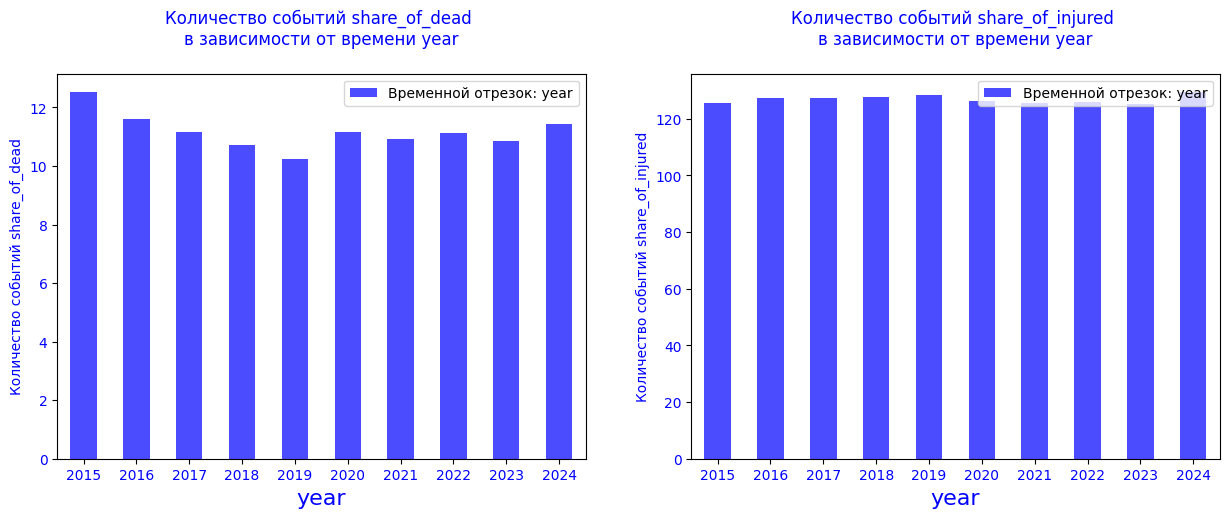

In [ ]:
dist_in_time(data_date_grupped, 'year', 'mean')

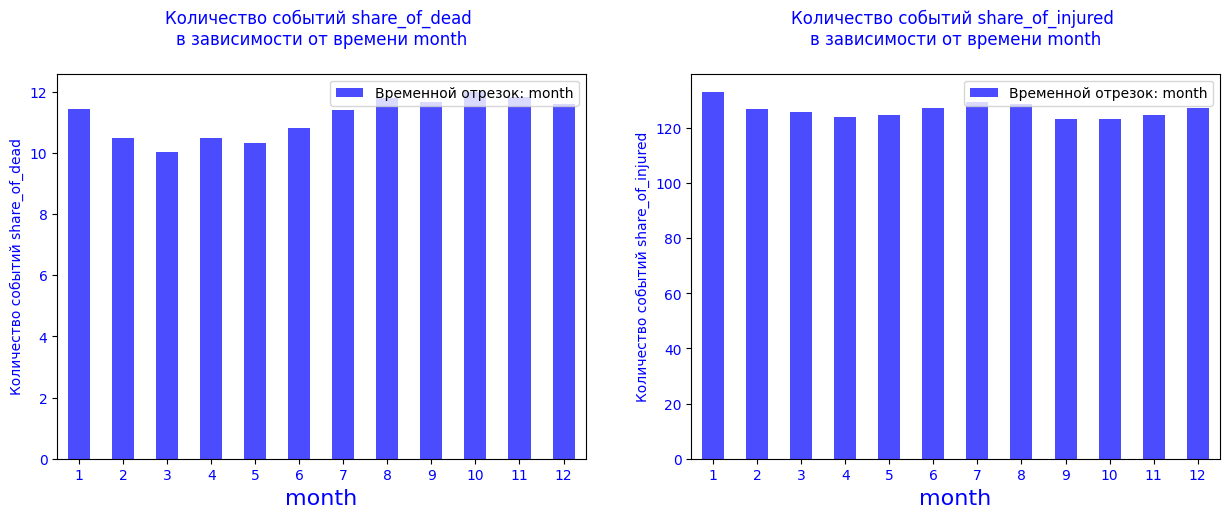

In [ ]:
dist_in_time(data_date_grupped, 'month', 'mean')

Чтобы проверить, является ли эта корреляция статистически значимой, мы можем рассчитать p-значение, связанное с коэффициентом корреляции Пирсона, с помощью Scipy pearsonr(), которая возвращает коэффициент корреляции Пирсона вместе с двусторонним p-значением.

In [ ]:
# Посмотрим связь между годом и Долей количества погибшихи людей / травмированых людей к количеству происшествий
# Для параметрического ряда рассчиаем ранговую корреляцию Пирсона
for i in data_date_grupped_year.columns[-2:]:
  print('Для показателя ', i)
  display(pearsonr(data_date_grupped_year['year'], data_date_grupped_year[i]))
  print('-'*40)



Для показателя  share_of_dead


PearsonRResult(statistic=-0.45061880334652693, pvalue=0.19122347473108853)

----------------------------------------
Для показателя  share_of_injured


PearsonRResult(statistic=0.023743851400899352, pvalue=0.9480895972122848)

----------------------------------------


Для обоих показателей двустороннее значение p значительно превышает общепринятое значение уровня статистической значимости 0.05. Мы можем заключить, что корреляция между долей количества погибшихи людей / травмированых людей к количеству происшествий не является статистически значимой.   
Пока у нас нет оснований считать, что с течением времени происшествия становятся несколько менее тяжелыми


### Проведем статистический тест
Сравним Показатели:
- количество смертельных случаев
- количество травмированных и раненых
- доля смертельных случаев относительно количества происшествий
- доля травм и ранений относительно количества происшествий

Чтобы исключить влияние краткосрочных факторов, сравнение произведем за период три последних года к трем предшествующим годам. То есть период 2021-2023 годов включительно сравним с периодом 2018-2020 годов включительно  



Создадим датасеты (выборки) за период 2021-2023 годы (категоризируем как 1) и за период 2018-2020 годы (категоризируем как 0)

In [ ]:
years_21_23 = data_date.loc[(data_date['year'] >= 2021) & (data_date['year'] <= 2023)]
years_18_20 = data_date.loc[(data_date['year'] >= 2018) & (data_date['year'] <= 2020)]

И посмотрим соотношение между количеством сметрельных случаев  для обоих периодов

#### Сформулируем нулевую гипотезу:
Среднее число погибших в ДТП в 2021-2023 годах не больше , чем среднее число погибших в ДТП в 2018-2020 годах

In [ ]:
prepear_test(years_21_23, years_18_20, 'dead_count', 'years_21_23', 'years_18_20', "в 2021 - 2023", 'greater')

years_21_23
    всего ДТП - 391980
    ДТП с dead_count - 36851
    ДТП без dead_count  - 355129
    Процент ДТП с dead_count 9.40%
years_18_20
    всего ДТП - 477761
    ДТП с dead_count - 43865
    ДТП без dead_count  - 433896
    Процент ДТП с dead_count 9.18%
--------------------
Посчитаем статистику, проведем z-test

          пропорция успехов в первой группе p1 =  0.09401244961477627 
          пропорция успехов во второй группе p2 = 0.09181368927141395
          пропорция успехов в комбинированном датасете p_combined = 0.09280463954211655
          разница пропорций в датасетах difference =  0.0021987603433623187
          z_value 3.5162923126547425
p-значение:  0.00021880944343721787
Отвергаем нулевую гипотезу: доля c dead_count в 2021 - 2023 больше, есть значимая разница
--------------------
Проведем t-test
p-значение:  0.00039848708736695156
Нулевая гипотеза отвергнута.  Для dead_count среднее значение распределения years_21_23 выше, чем years_18_20


In [ ]:
# для случая, если поменять местами выборки

#prepear_test( years_18_20, years_21_23, 'dead_count',  'years_18_20', 'years_21_23', "в 2021 - 2023", 'greater')

#### Результат проверки гипотезы
- Мы видим, что процент погибших в ДТП в обоих периодах примено одиноковый
- Проведенные тесты отвергают нулевую гипотезу о том, что Среднее число погибших в ДТП в 2021-2023 годах не больше , чем среднее число погибших в ДТП в 2018-2020 годах
 **То есть люди в 2021-2023 годах погибают в ДТП НЕ РЕЖЕ, чем в 2018-2020 годах**


#### Проверим гипотезу с точки зрения получивших повреждения и ранения в ДТП

Сформулируем нулевую гипотезую  
Среднее число получивших повреждения и ранения  в ДТП в 2021-2023 годах не больше , чем среднее число получивших повреждения и ранения  в ДТП в 2018-2020 годах

In [ ]:
prepear_test(years_21_23, years_18_20, 'injured_count', 'years_21_23', 'years_18_20', "в 2021 - 2023", 'greater')

years_21_23
    всего ДТП - 391980
    ДТП с injured_count - 368734
    ДТП без injured_count  - 23246
    Процент ДТП с injured_count 94.07%
years_18_20
    всего ДТП - 477761
    ДТП с injured_count - 450194
    ДТП без injured_count  - 27567
    Процент ДТП с injured_count 94.23%
--------------------
Посчитаем статистику, проведем z-test

          пропорция успехов в первой группе p1 =  0.9406959538751977 
          пропорция успехов во второй группе p2 = 0.942299601683687
          пропорция успехов в комбинированном датасете p_combined = 0.9415768602377029
          разница пропорций в датасетах difference =  -0.0016036478084893169
          z_value -3.172714476799453
p-значение:  0.0007551048295347806
Отвергаем нулевую гипотезу: доля c injured_count в 2021 - 2023 больше, есть значимая разница
--------------------
Проведем t-test
p-значение:  1.0
Не удалось отвергнуть нулевую гипотезу.  Для injured_count среднее значение распределения years_21_23 не выше, чем years_18_20


Результатам какого теста следует отдать приоритет?

[Для Z-теста требуется большой размер выборки (n ≥ 30) и известная дисперсия генеральной совокупности (или отклонение). Если дисперсия генеральной совокупности неизвестна, используйте t-тест, который использует выборочное стандартное отклонение (s).](https://www.reneshbedre.com/blog/z-test-in-python.html)  

[Большие выборки (n>= 30), взятые из совокупности (N), демонстрируют приблизительное нормальное распределение средних значений выборки в соответствии с Центральной предельной теоремой (CLT). Для больших выборок может использоваться тестовая статистика z (z-score), соответствующая стандартному нормальному распределению (z distribution). Для данных меньшего размера выборки можно использовать тестовую статистику t (tкритерийСтьюдента)](https://www.reneshbedre.com/blog/hypothesis-testing)  

Несмотря на то, что правосторонний t-тест Стьюдента показывает нам, что среднее погибших в ДТП в 2021-2023 годах не больше (МЕНЬШЕ), чем в 2018-2020 годах, мы должны отдать предпочтение параметрическому z-тесту.   
Но теория призывает нас проверить: известна ли нам дисперсия генеральной совокупности.   
В нашем исследовании мы ограничены выборками из генеральной совокупности. Прверить можем только дисперию предоставленных нам данных, которая по сути также является выборкой. И тем не менее - проверим.


In [ ]:
count_dispertion = [data_date]

In [ ]:
for i in count_dispertion:
  data = i.injured_count.to_list()
  print(variance(data))

0.8071383758055428


Да, нам известна дисперсия выборки из совокупности, которая представляет собой весь фрейм представленных нам данных

#### Результат проверки гипотезы
- Мы видим, что процент получивших травмы в ДТП в обоих периодах примено одиноковый
- Проведенные тесты отвергают нулевую гипотезу о том, что Среднее число получивших повреждения и ранения в ДТП в 2021-2023 годах не больше , чем среднее число получивших повреждения и ранения в ДТП в 2018-2020 годах
 **То есть люди в 2021-2023 годах получают травмы НЕ РЕЖЕ, чем в 2018-2020 годах**

## 3.3. В личном автомобиле ехать безопаснее чем в автобусе.

Загрузим  файл `data_vehicles`  
и посмотрим, какие транспортные средства обозначены в столбце `category`

In [ ]:
with open("data_vehicles.pickle", 'rb') as file:
    data_vehicles = pickle.load(file)

In [ ]:
# понизим регистр
data_vehicles.category = data_vehicles.category.str.lower()

In [ ]:
# какие транспортные средства обозначены в столбце category
data_vehicles.category.unique().tolist()

['прочие одноярусные',
 'с-класс (малый средний, компактный) до 4,3 м',
 'седельные тягачи',
 'бортовые грузовые автомобили',
 'd-класс (средний) до 4,6 м',
 'в-класс (малый) до 3,9 м',
 'прочие легковые автомобили',
 'фургоны',
 'е-класс (высший средний, бизнес-класс) до 4,9 м',
 'самосвалы',
 'мотоциклы',
 'спортивные (гоночные)',
 'рефрижераторы',
 'велосипеды',
 'мопеды с двигателем внутреннего сгорания менее 50 см. куб.',
 'минивэны и универсалы повышенной вместимости',
 'прочие грузовые автомобили',
 'одноэтажные длиной от 8 до 12 м',
 'мопеды с двигателем внутреннего сгорания более 50 см. куб.',
 'одноэтажные длиной не более 5 м',
 'прочая спецтехника',
 'а-класс (особо малый) до 3,5 м',
 'бортовые',
 'тракторы',
 'цистерны',
 'оснащённые специализированным оборудованием  автотранспортные средства для коммунального хозяйства и  содержания дорог',
 'не заполнено',
 'иные дорожно-строительные и дорожно-эксплуатационные машины и механизмы',
 'прочие самоходные машины и механизмы',



Вполне возможно, что Заказчик ставит целью выявить и предложить гражданам, как безопаснее перемещаться - на личном автомобиле или на общественном транспорте
В свете категорий:
- мы не можем выделить - из автомобилей - является автомобиль в личной собственности граждан, или это собственность компании, государства, либо это наемный транспорт - такси, каршеринг
- мы также не можем выявить автобусы - относятся к рейсовым или туристическим
В этой связи мы будем оценивать:
-  личные автомобили - как любой легковой автомобиль, включая автомобили представительского класса.
- автобусы - вне зависимости, это рейсовый или туристический автобус. Также к автобусам мы отнесем общественный транспорт, осуществляющий перевозки пассажиров:
- внутри населенных пунктов — это троллейбусы, трамваи и электробусы.
- 'Школьные автобусы'
- специализированные, ведомственные автобусы на базе шасси грузовых автомобилей таких, как, к примеру, КАМАЗ, Урал, ГАЗ и прочее.

Но мы разобьем задачу на части:
- сравним безопасность в целом - легковые автомобили и автобусы
- ~сравним безопасность в черте населенных пунктов- сравним безопасность за пределами населенных пунктов.~

Также было бы интересно посмотреть - а вообще в целом - насколько часто попадают автобусы и легковые автомобили в ДТП - но в рамках имеющихся данных это не представляется возможным.
Поэтому мы сравним:
- количество погибших
- количество пострадавших
- ~и попробуем определить - кто чаще становится виновником ДТП в тех случаях, когда одной из сторон ДТП являются легковой автомобиль или автобус.~

Учитывая сказанное:
К личным автомобилям отнесем записи в столбце `category`, содержащие слова:
- "класс", в том числе 'S-класс', несмотря на то, что эти автомашины далеко не всегда относятся к категории личных автомобилей. Заметим, что корректность отнесения конкретных марок автомобилей к тому или иному классу требует корректировки, если будет задача, связанная с , скажем, безопасностью автомобилей того или иного класса.
- ‘легковы’ – сюда попадут 'Прочие легковые автомобили' и 'Легковые автомобили (без типа)' и 'Прицепы к легковым автомобилям'

- 'спортивные'
- 'минивэны'
- 'автодома'

К автобусам отнесем записи в столбце `category`, содержащие слова (части слов):
- 'бусы' – сюда попадут Школьные автобусы, Автобусы (без типа), троллейбусы, Электробусы
- ‘одно’ – сюда попадут одноярусные и одноэтажные автобусы
- ‘двух’ – сюда попадут двухярусные и двухэтажные автобусы
- 'трамваи'



In [ ]:
# оставим для рассмотрения только столбцы id и category
mobile_bus = data_vehicles[['id', 'category']].copy()

In [ ]:
# удалим за ненадобностью датафрейм
del data_vehicles

Произведем категоризацию категорий транспорта.
Распределим на автомобли, автобусы и прочее

In [ ]:
# Создадим список категорий, которые мы отнесем к легковым автомобилям
list_mobile = []
list_bus = []
for i in mobile_bus.category.unique().tolist():
  for j in ["класс", 'легковы', 'спортивные', 'минивэны', 'автодома']:
      if j in i:
          list_mobile.append(i)
  for k in ["бусы", 'одно', 'двух', 'трамваи']:
      if k in i:
          list_bus.append(i)
print(list_mobile)
print(list_bus)

['с-класс (малый средний, компактный) до 4,3 м', 'd-класс (средний) до 4,6 м', 'в-класс (малый) до 3,9 м', 'прочие легковые автомобили', 'е-класс (высший средний, бизнес-класс) до 4,9 м', 'спортивные (гоночные)', 'минивэны и универсалы повышенной вместимости', 'а-класс (особо малый) до 3,5 м', 'легковые автомобили (без типа)', 's-класс (высший, представительский класс) более 4,9 м', 'автодома', 'прицепы к легковым автомобилям']
['прочие одноярусные', 'одноэтажные длиной от 8 до 12 м', 'одноэтажные длиной не более 5 м', 'школьные автобусы', 'одноэтажные длиной от 5 до 8 м', 'автобусы (без типа)', 'прочие одноэтажные', 'одноэтажные, сочлененные длиной более 12 м', 'трамваи', 'троллейбусы', 'двухярусные', 'двухэтажные', 'электробусы']


In [ ]:
# создадим словарь для категоризации категорий транспортных средств
dict_type = {}
for i in list_mobile:
  dict_type[i] = 'mobile'
for j in list_bus:
  dict_type[j] = 'bus'

In [ ]:
dict_type

{'с-класс (малый средний, компактный) до 4,3 м': 'mobile',
 'd-класс (средний) до 4,6 м': 'mobile',
 'в-класс (малый) до 3,9 м': 'mobile',
 'прочие легковые автомобили': 'mobile',
 'е-класс (высший средний, бизнес-класс) до 4,9 м': 'mobile',
 'спортивные (гоночные)': 'mobile',
 'минивэны и универсалы повышенной вместимости': 'mobile',
 'а-класс (особо малый) до 3,5 м': 'mobile',
 'легковые автомобили (без типа)': 'mobile',
 's-класс (высший, представительский класс) более 4,9 м': 'mobile',
 'автодома': 'mobile',
 'прицепы к легковым автомобилям': 'mobile',
 'прочие одноярусные': 'bus',
 'одноэтажные длиной от 8 до 12 м': 'bus',
 'одноэтажные длиной не более 5 м': 'bus',
 'школьные автобусы': 'bus',
 'одноэтажные длиной от 5 до 8 м': 'bus',
 'автобусы (без типа)': 'bus',
 'прочие одноэтажные': 'bus',
 'одноэтажные, сочлененные длиной более 12 м': 'bus',
 'трамваи': 'bus',
 'троллейбусы': 'bus',
 'двухярусные': 'bus',
 'двухэтажные': 'bus',
 'электробусы': 'bus'}

In [ ]:
# Произведем категоризацию и в столбец type_vehicle укажем тип транспортного средства
mobile_bus['type_vehicle'] = mobile_bus['category'].map(dict_type)
# Поскольку нас интересуют только автомобили и автобусы, удалим пустые записи
mobile_bus = mobile_bus[mobile_bus.type_vehicle.notna()]

In [ ]:
len(mobile_bus)

1819455

In [ ]:
# Избавимся от столбца category
mobile_bus = mobile_bus[['id', 'type_vehicle']].copy()

In [ ]:
# Поскольку в ДТП могут участвовать не только автомобиль и автобус ,
# но и два (или несколько) автомобиля или два (или несколько) автобусов,
# удалим дубликаты
mobile_bus = mobile_bus.drop_duplicates().reset_index(drop=True)

In [ ]:
len(mobile_bus)

1307981

In [ ]:
# Посмотрим на происшествия, где один из участников - автобус
for i in mobile_bus.query('type_vehicle == "bus"').id.head(20).tolist():
  display(mobile_bus.query('id == @i'))

,id,type_vehicle
0,2525237,bus


,id,type_vehicle
49,2058955,bus


,id,type_vehicle
56,2767791,bus


,id,type_vehicle
67,2823528,bus


,id,type_vehicle
121,2579216,bus


,id,type_vehicle
127,2060974,bus


,id,type_vehicle
155,2064557,bus


,id,type_vehicle
159,2064251,mobile
160,2064251,bus


,id,type_vehicle
237,2062020,bus


,id,type_vehicle
241,2650328,bus


,id,type_vehicle
285,2662859,bus


,id,type_vehicle
291,2837900,mobile
292,2837900,bus


,id,type_vehicle
329,2698079,bus


,id,type_vehicle
387,2063154,mobile
388,2063154,bus


,id,type_vehicle
416,2058487,mobile
417,2058487,bus


,id,type_vehicle
475,2890625,bus


,id,type_vehicle
479,2780247,bus


,id,type_vehicle
530,2064253,bus


,id,type_vehicle
536,2061586,mobile
537,2061586,bus


,id,type_vehicle
568,2059930,bus
569,2059930,mobile


Увидим, что в некоторых ДТП фигрируют как автобус, так и автомобиль.  
Но так или иначе, в таком ДТП присутствует автобус.  
Поэтому заменим в таких ДТП значение `mobile` на `bus`.  
После чего вновь удалим дубликаты


In [ ]:
mobile_bus['type_vehicle'].value_counts()

mobile    1203497
bus        104484
Name: type_vehicle, dtype: int64

In [ ]:
#mobile_bus = mobile_bus.sort_values('type_vehicle')

In [ ]:
# заменим в ДТП. где присутствует автобус, значение mobile на bus.
# но сначала отсортируем по значениям столбца type_vehicle для корректности замены
mobile_bus = mobile_bus.sort_values('type_vehicle')
mobile_bus.loc[mobile_bus['id'].duplicated(), 'type_vehicle'] = 'bus'

In [ ]:
# Вновь удалим дубликаты
mobile_bus = mobile_bus.drop_duplicates().reset_index(drop=True)

In [ ]:
mobile_bus.type_vehicle.value_counts()

mobile    1165286
bus        104484
Name: type_vehicle, dtype: int64

#### Из основного датасета присоединим погибших и пострадавших, также количество человек в транспортных средствах. И посмотрим, что у нас получилось.  
Загрузим столбцы id и число погибших.

In [ ]:
# Загрузим основную базу
# Нам достаточно для исследования данных по пострадавшим и погибшим
with open("data_base.pickle", 'rb') as file:
    data_base = pickle.load(file)[['id','injured_count', 'dead_count']]

In [ ]:
# в переменную foot_part_count для каждого происшествия сохраним количество людей,
# находившихся в транспортных средствах в момент ДТП

#foot_part_count =
data_foot_part.groupby('id').agg({'role':'count'}).sort_values('role', ascending = False)

,role
id,
2531060,59
2531661,58
2531677,55
2531742,54
2537829,53
...,...
1926789,1
1926778,1
2648129,1


In [ ]:
# Объединяем датасеты.
mobile_bus = mobile_bus.merge(data_base, on = 'id', how = 'left')
mobile_bus = mobile_bus.merge(data_foot_part.groupby('id').agg({'role':'count'}), on = 'id', how = 'left')
mobile_bus.columns = mobile_bus.columns.str.replace('role', 'total_people_count')
mobile_bus.total_people_count = mobile_bus.total_people_count.astype('int8')

In [ ]:
# Создадим небольшую формулу для лямбда-функции
fn = lambda x, y: x / y

In [ ]:
# Добавим столбцы с долями пострадавших и погибщих от общего количества человек в транспортных стредстах на момент ДТП
mobile_bus['injured_percent'] = fn(mobile_bus['injured_count'], mobile_bus['total_people_count'])
mobile_bus['dead_percent'] = fn(mobile_bus['dead_count'], mobile_bus['total_people_count'])


In [ ]:
mobile_bus.sort_values('total_people_count').tail(5)

,id,type_vehicle,injured_count,dead_count,total_people_count,injured_percent,dead_percent
130,2537829,bus,47,4,53,0.886792,0.075472
100335,2531742,bus,3,0,54,0.055556,0.000000
45411,2531677,bus,44,11,55,0.800000,0.200000
69639,2531661,bus,43,15,58,0.741379,0.258621
15752,2531060,bus,57,2,59,0.966102,0.033898


In [ ]:
# оценим средние доли пострадавших и погибших в ДТП с участием автомобилей и автобусов

mobile_bus.groupby('type_vehicle').agg({'id':'count', 'injured_percent':'mean',	'dead_percent':'mean'})

,id,injured_percent,dead_percent
type_vehicle,,,
bus,104484,0.472996,0.022214
mobile,1165286,0.530818,0.046441


In [ ]:
# В разрезе пьяных и трезвых ДТП посмотрим общее количество происшествий
# и происшествий со смертельным исходом: максимальное, среднее и общее количество погибших
#
mobile_bus.groupby('type_vehicle')['dead_count'].agg(['count','max','mean','sum'])

,count,max,mean,sum
type_vehicle,,,,
bus,104484,20,0.070547,7371
mobile,1165286,10,0.111069,129427


Количество ДТП с участием автобуса в 11 раз меньше количества ДТП с участием автомобиля.  
Доли пострадавших в ДТП примерно одинаковы, хотя в происшествиях с автобусами из все-же меньше на 6%.  
А вот доли погибших в ДТП различаются значительно  - в два раза меньше погибших в ДТП с участием автобуса.


In [ ]:
pd.options.display.float_format = '{:.4}'.format

In [ ]:
# Посмотрим распределение
mobile_bus.describe().round(3)

,id,injured_count,dead_count,total_people_count,injured_percent,dead_percent
count,1.27e+06,1.27e+06,1.27e+06,1.27e+06,1.27e+06,1.27e+06
mean,2.235e+06,1.297,0.108,2.539,0.526,0.044
std,4.097e+05,0.923,0.388,1.22,0.239,0.157
min,1.527e+06,0.0,0.0,1.0,0.0,0.0
25%,1.877e+06,1.0,0.0,2.0,0.5,0.0
50%,2.235e+06,1.0,0.0,2.0,0.5,0.0
75%,2.588e+06,1.0,0.0,3.0,0.5,0.0
max,2.949e+06,57.0,20.0,59.0,6.0,3.0


Из описательных статистик видно, что максимальное число погибших составляет 20 человек.

Для проведения теста произведем замену категорий

In [ ]:
dict_for_test = {'mobile':0, 'bus':1}
mobile_bus['type_vehicle'] = mobile_bus['type_vehicle'].map(dict_for_test)

In [ ]:
# Посмотрим связь между числом погибших и видом транспорта.
# Для непараметрического ряда рассчиаем ранговую корреляцию Спирмена
mobile_bus[['type_vehicle','dead_count']].corr(method= 'spearman')

,type_vehicle,dead_count
type_vehicle,1.0,-0.03628
dead_count,-0.03628,1.0


Чтобы проверить, является ли эта корреляция статистически значимой, мы можем рассчитать p-значение, связанное с коэффициентом корреляции Спирмена, с помощью Scipy spearmanr(), которая возвращает коэффициент корреляции Спирмена вместе с двусторонним p-значением.

In [ ]:
spearmanr(mobile_bus[['type_vehicle','dead_count']])

SignificanceResult(statistic=-0.03628036141078212, pvalue=0.0)

Коэффициент корреляции равен –0.036, а двустороннее значение p = 0.0. Поскольку это значение p меньше общепринятого значения уровня статистической значимости 0.05, то мы можем заключить, что существует статистически значимая корреляция между двумя переменными. Зависимость незначительная и отрицательная, передвижение в автобусе несет меньшую вероятность гибели в ДТП

Повторим расчет для пострадавших в ДТП

In [ ]:
# Посмотрим связь между числом пострадавших и видом транспорта.
# Для непараметрического ряда рассчиаем ранговую корреляцию Спирмена
mobile_bus[['type_vehicle','injured_count']].corr(method= 'spearman')

,type_vehicle,injured_count
type_vehicle,1.0,0.0001499
injured_count,0.0001499,1.0


Чтобы проверить, является ли эта корреляция статистически значимой, мы можем рассчитать p-значение, связанное с коэффициентом корреляции Спирмена, с помощью Scipy spearmanr(), которая возвращает коэффициент корреляции Спирмена вместе с двусторонним p-значением.

In [ ]:
spearmanr(mobile_bus[['type_vehicle','injured_count']])

SignificanceResult(statistic=0.00014994756437917853, pvalue=0.865822712008135)

Коэффициент корреляции равен практически нулю, а двустороннее значение p = 0.86. Поскольку это значение p больше общепринятого значения уровня статистической значимости 0.05, то мы можем заключить, что не существует статистически значимая корреляция между двумя переменными. Передвижение в автобусе не снижает и не увеличивает вероятность получения травмы в ДТП

### Проведем статистический тест

Создадим датасеты (выборки) с происшествиями с автомобилями (0) и автобусами (1)

In [ ]:
df_mobile = mobile_bus[mobile_bus['type_vehicle'] == 0]

In [ ]:
df_bus = mobile_bus[mobile_bus['type_vehicle'] == 1]

И посмотрим соотношение между погибшими в ДТП  с автобусами и автомобилями внутри каждой группы.

#### Сформулируем нулевую гипотезу:
Среднее погибших в ДТП с автомобилями не больше , чем среднее погибших в ДТП с автобусами

In [ ]:
prepear_test(df_mobile, df_bus, 'dead_count', 'Автомобиль', 'Автобус', "в ДТП с Автомобилем")

Автомобиль
    всего ДТП - 1165286
    ДТП с dead_count - 108228
    ДТП без dead_count  - 1057058
    Процент ДТП с dead_count 9.29%
Автобус
    всего ДТП - 104484
    ДТП с dead_count - 5755
    ДТП без dead_count  - 98729
    Процент ДТП с dead_count 5.51%
--------------------
Посчитаем статистику, проведем z-test

          пропорция успехов в первой группе p1 =  0.09287677016629393 
          пропорция успехов во второй группе p2 = 0.055080203667547185
          пропорция успехов в комбинированном датасете p_combined = 0.08976665065326792
          разница пропорций в датасетах difference =  0.03779656649874675
          z_value 40.94464367626494
p-значение:  0.0
Отвергаем нулевую гипотезу: доля c dead_count в ДТП с Автомобилем больше, есть значимая разница
--------------------
Проведем t-test
p-значение:  9.349414250069204e-235
Нулевая гипотеза отвергнута.  Для dead_count среднее значение распределения Автомобиль выше, чем Автобус


#### Результат проверки гипотезы
- Мы видим, что процент ДТП с автобусом с погибшими  почти вдвое меньше, чем аналогичный показатель с автомобилями (где транспортные средства - только автомобили)
- Проведенные тесты отвергают нулевую гипотезу о том, что Среднее погибших в ДТП с автомобилями не больше , чем среднее погибших в ДТП с автобусами. **Мы не можем подтвердить, что в автомобиле ехать безопаснее, чем в автобусе**

#### Проверим расчет для пострадавших в ДТП (травмированных и получивших ранения)
Сформулируем нулевую гипотезу для пострадавших в ДТП:   
Среднее число пострадавших в ДТП с автомобилями не больше , чем среднее число пострадавших  в ДТП с автобусами

In [ ]:
prepear_test(df_mobile, df_bus, 'injured_count', 'Автомобиль', 'Автобус', "в ДТП с Автомобилем")

Автомобиль
    всего ДТП - 1165286
    ДТП с injured_count - 1101636
    ДТП без injured_count  - 63650
    Процент ДТП с injured_count 94.54%
Автобус
    всего ДТП - 104484
    ДТП с injured_count - 101090
    ДТП без injured_count  - 3394
    Процент ДТП с injured_count 96.75%
--------------------
Посчитаем статистику, проведем z-test

          пропорция успехов в первой группе p1 =  0.9453782161632424 
          пропорция успехов во второй группе p2 = 0.9675165575590521
          пропорция успехов в комбинированном датасете p_combined = 0.9471998865936351
          разница пропорций в датасетах difference =  -0.022138341395809724
          z_value -30.653880686477052
p-значение:  0.0
Отвергаем нулевую гипотезу: доля c injured_count в ДТП с Автомобилем больше, есть значимая разница
--------------------
Проведем t-test
p-значение:  1.0
Не удалось отвергнуть нулевую гипотезу.  Для injured_count среднее значение распределения Автомобиль не выше, чем Автобус


#### Результат проверки гипотезы
Вновь мы видим расхождение в результатах z и t тестов. Руководствуясь доводами, приведенными выше, отдадим приоритет параметрическому z-тесту.

- Мы видим, что процент ДТП с автобусом с пострадавшими лишь незначительно отличается (и превышает) от аналогичного показателя с автомобилями (где транспортные средства - только автомобили)
- Проведенные тесты отвергают нулевую гипотезу о том, что Среднее пострадавших в ДТП с автомобилями не больше , чем среднее пострадавших в ДТП с автобусами. **Мы не можем подтвердить, что в автомобиле ехать безопаснее, чем в автобусе**



## 3.4. Если пешеходы не будут нарушать, то не будут гибнуть

### Загрузим  файл `data_foot_part` и обработаем данные из него   
и посмотрим, какие роли людей зафиксированы в столбце `role`

In [ ]:
with open("data_foot_part.pickle", 'rb') as file:
    data_foot_part = pickle.load(file)

In [ ]:
# какие роли людей зафиксированы в столбце role
data_foot_part.role.unique().tolist()

['Водитель',
 'Пассажир',
 'Велосипедист',
 'Пешеход, перед ДТП находившийся в (на) ТС в качестве водителя или пешеход, перед ДТП находившийся в (на) ТС в качестве пассажира',
 'Пешеход']

- Мы не будем принимать в исследование категорию 'Пешеход, перед ДТП находившийся в (на) ТС в качестве водителя или пешеход, перед ДТП находившийся в (на) ТС в качестве пассажира', поскольку исследуем поведение пешеходов до момента ДТП
- Мы не включим в рассмотрение велосипедистов - поскольку их поверение, их роль отичается от поведения пешеходов.

In [ ]:
# Оставим для исследования только пешеходов. Сохраним данные в новом файле.
# Удалим загрузку
footers = data_foot_part.query('role == "Пешеход"').copy().reset_index(drop = True)

In [ ]:
del data_foot_part

In [ ]:
# проверим на пропущенные значения
footers.notna().mean()

id                            1.0
role                          1.0
gender                        1.0
violations                    1.0
health_status                 1.0
years_of_driving_experience   1.0
dtype: float64

In [ ]:
# Визуально проверим несколько дубликатов по ID
for i in footers.loc[footers['id'].duplicated(), 'id'].sample(10).tolist():
  display(footers.query('id ==@i'))

,id,role,gender,violations,health_status,years_of_driving_experience
118524,2121840,Пешеход,Женский,[],"Раненый, находящийся (находившийся) на амбула...",Не заполнено
118525,2121840,Пешеход,Мужской,[],"Раненый, находящийся (находившийся) на амбула...",Не заполнено


,id,role,gender,violations,health_status,years_of_driving_experience
23247,2513249,Пешеход,Мужской,[],"Раненый, находящийся (находившийся) на стацион...",Не заполнено
23248,2513249,Пешеход,Женский,[],"Раненый, находящийся (находившийся) на амбулат...",Не заполнено


,id,role,gender,violations,health_status,years_of_driving_experience
54139,1803397,Пешеход,Женский,[],Получил травмы с оказанием разовой медицинской...,Не заполнено
54140,1803397,Пешеход,Мужской,[],"Раненый, находящийся (находившийся) на стацион...",Не заполнено


,id,role,gender,violations,health_status,years_of_driving_experience
363293,1611658,Пешеход,Мужской,[Иные нарушения],Не пострадал,Не заполнено
363294,1611658,Пешеход,Женский,[Иные нарушения],"Раненый, находящийся (находившийся) на стацион...",Не заполнено
363295,1611658,Пешеход,Женский,[Иные нарушения],"Раненый, находящийся (находившийся) на стацион...",Не заполнено


,id,role,gender,violations,health_status,years_of_driving_experience
117884,2701867,Пешеход,Мужской,[],Получил телесные повреждения с показанием к ле...,Не заполнено
117885,2701867,Пешеход,Мужской,"[Пешеход в состоянии алкогольного опьянения, П...",Скончался на месте ДТП до приезда скорой медиц...,Не заполнено


,id,role,gender,violations,health_status,years_of_driving_experience
339485,1913688,Пешеход,Женский,[Переход через проезжую часть вне пешеходного ...,"Раненый, находящийся (находившийся) на стацион...",Не заполнено
339486,1913688,Пешеход,Женский,[],"Раненый, находящийся (находившийся) на амбула...",Не заполнено


,id,role,gender,violations,health_status,years_of_driving_experience
305148,1956851,Пешеход,Женский,[],"Раненый, находящийся (находившийся) на амбула...",Не заполнено
305149,1956851,Пешеход,Женский,[],"Раненый, находящийся (находившийся) на амбула...",Не заполнено
305150,1956851,Пешеход,Женский,[],"Раненый, находящийся (находившийся) на стацион...",Не заполнено
305151,1956851,Пешеход,Мужской,[],"Раненый, находящийся (находившийся) на стацион...",Не заполнено


,id,role,gender,violations,health_status,years_of_driving_experience
338858,1933517,Пешеход,Мужской,[],"Раненый, находящийся (находившийся) на стацион...",Не заполнено
338859,1933517,Пешеход,Мужской,[],"Раненый, находящийся (находившийся) на стацион...",Не заполнено
338860,1933517,Пешеход,Мужской,[],"Раненый, находящийся (находившийся) на стацион...",Не заполнено
338861,1933517,Пешеход,Мужской,[],"Раненый, находящийся (находившийся) на стацион...",Не заполнено
338862,1933517,Пешеход,Женский,[],"Раненый, находящийся (находившийся) на стацион...",Не заполнено
338863,1933517,Пешеход,Женский,[],"Раненый, находящийся (находившийся) на амбула...",Не заполнено
338864,1933517,Пешеход,Мужской,[],"Раненый, находящийся (находившийся) на стацион...",Не заполнено


,id,role,gender,violations,health_status,years_of_driving_experience
210721,2053766,Пешеход,Мужской,"[Иные нарушения, Нахождение на проезжей части ...",Скончался на месте ДТП до приезда скорой медиц...,Не заполнено
210722,2053766,Пешеход,Женский,"[Иные нарушения, Нахождение на проезжей части ...",Скончался на месте ДТП до приезда скорой медиц...,Не заполнено


,id,role,gender,violations,health_status,years_of_driving_experience
401308,2333850,Пешеход,Женский,[],Не пострадал,Не заполнено
401309,2333850,Пешеход,Женский,[],Не пострадал,Не заполнено
401310,2333850,Пешеход,Женский,[],"Раненый, находящийся (находившийся) на амбула...",Не заполнено


Видим, что если несколько пешеходов пострадали в одном ДТП, то это не связано с задвоением занесенных данных

In [ ]:
# Избавимся от столбцов 'role', 'gender', 'years_of_driving_experience'
footers = footers[['id', 'violations', 'health_status']]


In [ ]:
# какие виды ущерба здоровью зафиксированы в столбце health_status
footers.health_status.unique().tolist()

['Раненый, находящийся (находившийся) на амбулаторном лечении, либо в условиях дневного стационара',
 'Не пострадал',
 'Получил телесные повреждения с показанием к лечению в медицинских организациях (кроме разовой медицинской помощи)',
 'Скончался на месте ДТП до приезда скорой медицинской помощи',
 'Скончался при транспортировке',
 'Скончался в течение 1 суток',
 'Раненый, находящийся (находившийся) на стационарном лечении',
 'Раненый, находящийся (находившийся)  на амбулаторном лечении, либо которому по характеру полученных травм обозначена необходимость амбулаторного лечения (вне зависимости от его фактического прохождения)',
 'Скончался в течение 2 суток',
 'Скончался в течение 9 суток',
 'Скончался на месте ДТП по прибытию скорой медицинской помощи, но до транспортировки в мед. организацию',
 'Скончался в течение 7 суток',
 'Скончался в течение 10 суток',
 'Скончался в течение 6 суток',
 'Скончался в течение 16 суток',
 'Скончался в течение 4 суток',
 'Скончался в течение 15 суток

Виды ущерба здоровью можно отнести в 3 категории:
- Не пострадал
- Получил телесные повреждения или Получил травмы или Раненый (степень тяжести вреда здоровью)
- Скончался

Произведем категоризацию полученного ущерба. Заменим данные в столбце `health_status`

In [ ]:
# Создадим список категорий, которые мы отнесем к полученному вреду здоровья
def create_category_list(df):
  list_intact = []
  list_injured = []
  list_dead = []
  for i in df.health_status.unique().tolist():
    for j in ["Не пострадал"]:
        if j in i:
            list_intact.append(i)
    for k in ["Получил", 'Раненый']:
        if k in i:
            list_injured.append(i)
    for l in ["Скончался"]:
        if l in i:
            list_dead.append(i)
  #print(list_intact)
  #print(list_injured)
  #print(list_dead)

  # создадим словарь для категоризации вида ущерба здоровью
  dict_footers = {}
  for i in list_intact:
    dict_footers[i] = 'intact'
  for j in list_injured:
    dict_footers[j] = 'injured'
  for l in list_dead:
    dict_footers[l] = 'dead'

  return(dict_footers)

In [ ]:
# создадим словарь для категоризации вида ущерба здоровью
dict_footers = create_category_list(footers)

In [ ]:
# Произведем категоризацию и в столбец health_status укажем вид ущерба здоровью
footers['health_status'] = footers['health_status'].map(dict_footers)

<ipython-input-123-6760d7732599>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  footers['health_status'] = footers['health_status'].map(dict_footers)


In [ ]:
# Ознакомимся с уникальными значениями в столбце `violations`
footers.violations.explode().unique().tolist()

['Передвижение по проезжей части на скейтборде (роликовых коньках и т.д.)',
 'Движение вдоль проезжей части попутного направления вне населенного пункта при удовлетворительном состоянии обочины',
 'Отсутствие световозвращающих элементов',
 'Переход через проезжую часть вне пешеходного перехода в зоне его видимости либо при наличии в непосредственной близости подземного (надземного) пешеходного перехода',
 nan,
 'Нахождение на проезжей части без цели её перехода',
 'Переход через проезжую часть в неустановленном месте (при наличии в зоне видимости перекрёстка)',
 'Пешеход в состоянии алкогольного опьянения',
 'Иные нарушения',
 'Движение вдоль проезжей части при наличии и удовлетворительном состоянии тротуара',
 'Ходьба вдоль проезжей части попутного направления вне населенного пункта при удовлетворительном состоянии обочины',
 'Неожиданный выход из-за ТС',
 'Ходьба вдоль проезжей части при наличии и удовлетворительном состоянии тротуара',
 'Игра на проезжей части',
 'Переход проезжей ч

Видим, что присутствуют записи о тех или иных видах нарушения, либо запись отсутствует (nan).  
Очевидно, что в последнем случае отсутствие записи означает, что пешеход ничего не нарушал.  
Произведем категоризацию.
- Если нет нарушения - присвоим 0
- Если есть нарушение - присвоим 1

In [ ]:
# В столбце "violations" заменим значения и внесем длину записи в столбце "violations"
# Там, где длина равна 0 - пешеход не нарушил правила движения.
# Там, где длина больше 0 - пешеход нарушил одно или более правил двжения

footers['violations'] = footers['violations'].apply( lambda x: len(x) )

In [ ]:
# Не важно, сколько пунктов правил нарушил пешеход, важно, что он нарушил хотя бы одно
# Все значения в столбце violations, которые равны 1 или более - приравняем к 1
footers.loc[footers['violations']>0, 'violations'] = 1

In [ ]:
# Для проведения теста создадим колонки dead_count, injured_count, intact_count
# Используем функцию insert_column
# Заполним их значениями 1, если в колонке health_status указан соответствующий статус
for i in ['dead', 'injured', 'intact']:
  insert_column(footers, i)
  footers.loc[footers['health_status'] == i, i] = 1
# переименуем колонки
footers.rename(columns = {'dead':'dead_count', 'injured':'injured_count', 'intact':'intact_count'}, inplace = True )

In [ ]:
footers[['dead_count', 'injured_count']].mean()

dead_count      0.1014
injured_count   0.8946
dtype: float64

Мы подготовили датафрейм содержащий данные о:
- количестве ДТП
- наличии или отсутстви нарушения со стороны пешехода
- степени вреда здоровью пешехода


In [ ]:
footers.value_counts('violations')

violations
0    258097
1    166198
dtype: int64

In [ ]:
# Построим круговую диаграмму, отражающую распределение наличия и отсутствия нарушений со стороны пешехода
# Посчитаем количество клиентов в каждой группе
footers.groupby('violations').agg({'id':'count'})
#display(users_pie)

,id
violations,
0,258097
1,166198


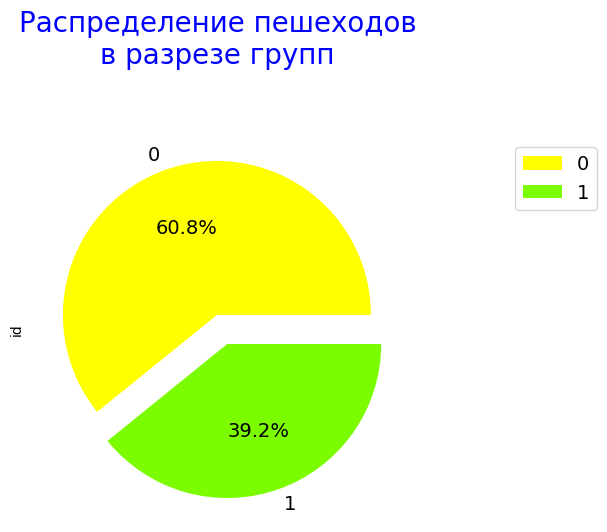

In [ ]:
# Построим круговую диаграмму, отражающую распределение наличия и отсутствия нарушений со стороны пешехода
# Посчитаем количество клиентов в каждой группе
#footers.groupby('violations').agg('id': 'count').sort_values(ascending=False)
#display(users_pie)


# Построим груговую диаграмму и увидим доли клиентов в группах
exp = (0.1,0.1)
footers.groupby('violations').agg({'id':'count'})\
            .plot(kind='pie',figsize=(5,5),colors = ['yellow','LawnGreen','DeepPink','DodgerBlue'], \
              autopct='%1.1f%%',fontsize=14, explode=exp, subplots=True)
plt.title('Распределение пешеходов \nв разрезе групп \n\n', fontsize=20, color = "b")
plt.legend(fontsize=14, bbox_to_anchor=(1.5, 1))
plt.xticks(rotation=0, fontsize=12, color = "b")
plt.yticks(rotation=0, fontsize=12, color = "b")

plt.show()

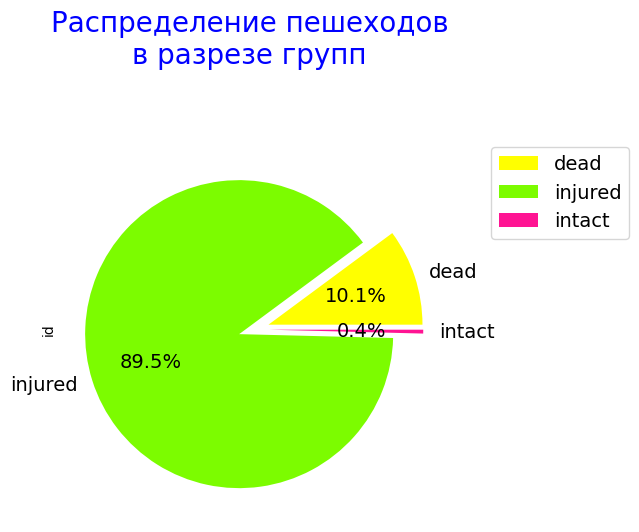

In [ ]:
# Построим круговую диаграмму, отражающую распределение степени тяжести вреда здоровью пешехода
exp = (0.1,0.1, 0.1)
footers.groupby('health_status').agg({'id':'count'})\
            .plot(kind='pie',figsize=(5,5),colors = ['yellow','LawnGreen','DeepPink','DodgerBlue'], \
              autopct='%1.1f%%',fontsize=14, explode=exp, subplots=True)
plt.title('Распределение пешеходов \nв разрезе групп \n\n', fontsize=20, color = "b")
plt.legend(fontsize=14, bbox_to_anchor=(1.5, 1))
plt.xticks(rotation=0, fontsize=12, color = "b")
plt.yticks(rotation=0, fontsize=12, color = "b")

plt.show()

- Примерно в 40% случаев пешеходы нарушили правида дорожного движения. Это не означает, что именно они были виновниками ДТП, Вполне возможно, что и водители транспортных средств также допустили нарушение
- В случае ДТП с пешеходом у последнего практически нет шансов не получить повреждения - таких лишь 0,4%. Почти 90% ДТП с участием пешехода приводят к травме или ранению послежнего. И еще в 10% случае такие ДТП приводят к гибели пешехода.  

### Найдем зависимость между нарушением пешеходом ПДД и сметрностью пешехода в ДТП

In [ ]:
footers.columns

Index(['id', 'violations', 'health_status', 'dead_count', 'injured_count',
       'intact_count'],
      dtype='object')

In [ ]:
# Посмотрим связь между нарушением пешехода и гибелью пешехода.
# Для непараметрического ряда рассчиаем ранговую корреляцию Спирмена
footers[['violations','dead_count']].corr(method= 'spearman')

,violations,dead_count
violations,1.0,0.2106
dead_count,0.2106,1.0


Чтобы проверить, является ли эта корреляция статистически значимой, мы можем рассчитать p-значение, связанное с коэффициентом корреляции Спирмена, с помощью Scipy spearmanr(), которая возвращает коэффициент корреляции Спирмена вместе с двусторонним p-значением.

In [ ]:
spearmanr(footers[['violations','dead_count']])

SignificanceResult(statistic=0.21063351052281032, pvalue=0.0)

Коэффициент корреляции равен 0.210, а двустороннее значение p = 0.0. Поскольку это значение p меньше общепринятого значения уровня статистической значимости 0.05, то мы можем заключить, что существует статистически значимая корреляция между двумя переменными. Зависимость средней значимости и положительная, нарушение пешеходами правил ПДД увеличивает вероятность их гибели

Повторим расчет для пострадавших в ДТП

In [ ]:
# Посмотрим связь между нарушением пешехода и получением травмы или ранения пешехода.
# Для непараметрического ряда рассчиаем ранговую корреляцию Спирмена
footers[['violations','injured_count']].corr(method= 'spearman')

,violations,injured_count
violations,1.0,-0.2058
injured_count,-0.2058,1.0


Чтобы проверить, является ли эта корреляция статистически значимой, мы можем рассчитать p-значение, связанное с коэффициентом корреляции Спирмена, с помощью Scipy spearmanr(), которая возвращает коэффициент корреляции Спирмена вместе с двусторонним p-значением.

In [ ]:
spearmanr(footers[['violations','injured_count']])

SignificanceResult(statistic=-0.20578171305289214, pvalue=0.0)

Коэффициент корреляции равен -0.206, а двустороннее значение p = 0.0. Поскольку это значение p меньше общепринятого значения уровня статистической значимости 0.05, то мы можем заключить, что существует статистически значимая корреляция между двумя переменными. Зависимость средней значимости и отрицательная, и говорит она о том, что пешеходы получают травмы у ранения больше, когда они соблюдают ПДД. Иначе говоря, не нарушение правил пешеходами являюеся причиной получения последними травм и ранений.

### Проведем статистический тест

Создадим датасеты (выборки) нарушением пешеходами ПДД (1) и отсутствием нарушения  пешеходами ПДД (0)

In [ ]:
df_violation = footers[footers['violations'] == 1]

In [ ]:
df_abidance = footers[footers['violations'] == 0]

И посмотрим соотношение между погибшими в ДТП  для соблюдающих и не соблюдающих ПДД пешеходов

Посмотрим долю ДТП с погибшими.

#### Сформулируем нулевую гипотезу:
Среднее число НЕ погибших пешеходов, которые не нарушили ПДД не больше , чем среднее число НЕ погибших пешеходов, которые нарушили ПДД

In [ ]:
prepear_test(df_violation, df_abidance, 'dead_count', 'Нарушили', 'Не нарушили', "в ДТП с нарушением Пешеходом ПДД")

Нарушили
    всего ДТП - 166198
    ДТП с dead_count - 30018
    ДТП без dead_count  - 136180
    Процент ДТП с dead_count 18.06%
Не нарушили
    всего ДТП - 258097
    ДТП с dead_count - 13000
    ДТП без dead_count  - 245097
    Процент ДТП с dead_count 5.04%
--------------------
Посчитаем статистику, проведем z-test

          пропорция успехов в первой группе p1 =  0.18061589188798902 
          пропорция успехов во второй группе p2 = 0.050368659844942015
          пропорция успехов в комбинированном датасете p_combined = 0.10138700668167196
          разница пропорций в датасетах difference =  0.130247232043047
          z_value 137.2023098586056
p-значение:  0.0
Отвергаем нулевую гипотезу: доля c dead_count в ДТП с нарушением Пешеходом ПДД больше, есть значимая разница
--------------------
Проведем t-test
p-значение:  0.0
Нулевая гипотеза отвергнута.  Для dead_count среднее значение распределения Нарушили выше, чем Не нарушили


#### Результат проверки гипотезы
- Мы видим, что процент погибших в ДТП пешеходов в случае, если они соблюдали ПДД, в три с половиной раза меньше, чем аналогичный показатель в случае, когда пешеходы не соблюдали ПДД.
- Проведенные тесты отвергают нулевую гипотезу о том, что Среднее число НЕ погибших пешеходов, которые не нарушили ПДД не больше , чем среднее число НЕ погибших пешеходов, которые нарушили ПДД. **То есть Пешеход меньше(реже) погибает, если не нарушает ПДД**. или же Пешеход больше (чаще) не погибает, если не нарушает ПДД


#### Проверим гипотезу с точки зрения получивших повреждения и ранения пешеходов   
Нулевая гипотеза Н0:
Среднее число **НЕ получивших повреждения** пешеходов, которые не нарушили ПДД не больше , чем среднее число НЕ получивших повреждения пешеходов, которые нарушили ПДД

In [ ]:
 prepear_test(df_violation, df_abidance, 'injured_count', 'Нарушили', 'Не нарушили', "в ДТП с нарушением Пешеходом ПДД")

Нарушили
    всего ДТП - 166198
    ДТП с injured_count - 135596
    ДТП без injured_count  - 30602
    Процент ДТП с injured_count 81.59%
Не нарушили
    всего ДТП - 258097
    ДТП с injured_count - 243983
    ДТП без injured_count  - 14114
    Процент ДТП с injured_count 94.53%
--------------------
Посчитаем статистику, проведем z-test

          пропорция успехов в первой группе p1 =  0.8158702270785448 
          пропорция успехов во второй группе p2 = 0.945315133457576
          пропорция успехов в комбинированном датасете p_combined = 0.8946110607006917
          разница пропорций в датасетах difference =  -0.12944490637903117
          z_value -134.04194939085932
p-значение:  0.0
Отвергаем нулевую гипотезу: доля c injured_count в ДТП с нарушением Пешеходом ПДД больше, есть значимая разница
--------------------
Проведем t-test
p-значение:  1.0
Не удалось отвергнуть нулевую гипотезу.  Для injured_count среднее значение распределения Нарушили не выше, чем Не нарушили


#### Результат проверки гипотезы
- Отдаем приоритет результатам z-теста
- Мы видим, что процент получивших травмы в ДТП пешеходов в случае, если они соблюдали ПДД, несколько превышает аналогичный показатель в случае, когда пешеходы не соблюдали ПДД. Кстати, в случае с гипотезой автобус/автомобиль мы тоже видели такое соотношение.
- Проведенные тесты позволяют отвергнуть нулевую гипотезу о том, Среднее число НЕ получивших повреждения пешеходов, которые не нарушили ПДД не больше , чем среднее число НЕ получивших повреждения пешеходов, которые нарушили ПДД. **То есть Пешеход реже получает травмы, когда не нарушает ПДД** (нежели когда их нарушает).
- С другой стороны, если бы мы могли отдать предпочтение результатам t-теста, то мы могли бы предположить, что когда пешеход нарушает ПДД - он получает травмы более серьезные, которые приводят к его гибели (сметри).

## 3.5. Низкая скорость не влияет на тяжесть ДТП.  
В гипотезе мы хотим проверить влияние низкой скорости.  
Но у нас отсутствуют как значения скорости, с которой двигалось транспортное средство, так и критерий. который устанавливал бы границу, порог, до которого скорость трактовалась бы как низкая.  
С другой стороны, у нас есть возможность выявить в числе нарушений соблюдение или не соблюдение водителем установленного скоростного режима.  
Учитывая сказанное, построим исследование на сопоставлении последствий ДТП при соблюдении или не соблюдении водителями скоростного режима.



### Загрузим  файл `data_foot_part` и обработаем данные из него   


и посмотрим, какие роли людей зафиксированы в столбце `role`

In [ ]:
with open("data_foot_part.pickle", 'rb') as file:
    data_foot_part = pickle.load(file)

In [ ]:
# какие роли людей зафиксированы в столбце role
data_foot_part .role.unique().tolist()

['Водитель',
 'Пассажир',
 'Велосипедист',
 'Пешеход, перед ДТП находившийся в (на) ТС в качестве водителя или пешеход, перед ДТП находившийся в (на) ТС в качестве пассажира',
 'Пешеход']

Очевидно, что соблюдение или несоблюдение скоростного режима допускают водители транспортных средств. Но пешеходы и пассажиру также являются участнтками таких ДТП, одной из причин которой стало несоблюдение скорости. Поэтому в рассмотрении оставим все категории участников.

In [ ]:
# Сохраним данные в новом файле.
# Удалим загрузку
speed = data_foot_part.copy().reset_index(drop = True)

In [ ]:
del data_foot_part

In [ ]:
# Сохраним в датафрейме только требуемые для исследования столбцы
speed = speed[['id',  'violations', 'health_status'
       #,'years_of_driving_experience'
       ]]

In [ ]:
# проверим на пропущенные значения
speed.notna().mean()

id              1.0
violations      1.0
health_status   1.0
dtype: float64

In [ ]:
# Визуально проверим несколько дубликатов по ID
for i in speed.loc[speed['id'].duplicated(), 'id'].sample(10).tolist():
  display(speed.query('id ==@i'))

,id,violations,health_status
1931140,2446526,[Другие нарушения ПДД водителем],Не пострадал
1931141,2446526,[],Не пострадал
1931142,2446526,[],Не пострадал
1938369,2446526,[],"Раненый, находящийся (находившийся) на амбула..."


,id,violations,health_status
1973430,2897903,[],Не пострадал
2030303,2897903,[Переход через проезжую часть вне пешеходного ...,Получил телесные повреждения с показанием к ле...


,id,violations,health_status
1702265,1814985,[],Не пострадал
1702266,1814985,[],"Раненый, находящийся (находившийся) на амбула..."
1702267,1814985,[Другие нарушения ПДД водителем],Не пострадал


,id,violations,health_status
184497,2638663,[],Не пострадал
184498,2638663,[Несоблюдение очередности проезда],"Раненый, находящийся (находившийся) на амбулат..."


,id,violations,health_status
1297022,2651384,[],"Раненый, находящийся (находившийся) на стацион..."
1297023,2651384,[],"Раненый, находящийся (находившийся) на стацион..."
1297024,2651384,[Несоблюдение очередности проезда],"Раненый, находящийся (находившийся) на амбулат..."


,id,violations,health_status
804250,1715314,[],Не пострадал
804251,1715314,[],Не пострадал
804252,1715314,[],"Раненый, находящийся (находившийся) на амбулат..."
804253,1715314,[],"Раненый, находящийся (находившийся) на амбулат..."
804254,1715314,[Нарушение правил обгона],"Раненый, находящийся (находившийся) на амбулат..."


,id,violations,health_status
1853952,2390900,[],Не пострадал
1853953,2390900,[],"Раненый, находящийся (находившийся) на амбула..."
1853954,2390900,[Другие нарушения ПДД водителем],Не пострадал


,id,violations,health_status
1898521,2785766,[Нарушение правил расположения ТС на проезжей ...,Не пострадал
1908041,2785766,[Иные нарушения],"Раненый, находящийся (находившийся) на стацион..."


,id,violations,health_status
2470524,2434999,[Другие нарушения ПДД водителем],Не пострадал
2480549,2434999,[],"Раненый, находящийся (находившийся) на стацион..."


,id,violations,health_status
2743137,2925740,[Нарушение правил проезда пешеходного перехода...,Не пострадал
2796861,2925740,[],"Раненый, находящийся (находившийся) на амбулат..."


Видим, что если несколько водителей участвуют в одном ДТП, то это не связано с задвоением занесенных данных

In [ ]:
# Посмотрим перечень нарушений и найдем в нем нарушения, связанные со скороcтным режимом
a5 = sorted(speed.violations.explode().fillna('НЕТ НАРУШЕНИЯ').unique().tolist())

In [ ]:
# Выделим нарушения, связанные со со скоростным режимом
# и сохраним их в переменную list_speed
list_speed = []
for i in a5:
  if 'скор' in i:
    list_speed.append(i)

print(list_speed)

['Несоответствие скорости конкретным условиям движения', 'Превышение установленной скорости движения']


Таким образом, участвуя в ДТП водитель мог соблюдать и не соблюдать скоростной режим.  

Произведем категоризацию ДТП в зависимости от нарушения скоростного режима.  
Установим значение:
- 0 - если нарушений скорости не было
- 1 - если нарушения скорости были

Занесем данные в столбц `speed_violations`

In [ ]:
# Создадим столбец speed_violations
# Воспользуемся функцией insert_column
insert_column(speed, 'speed_violations')

In [ ]:
#speed['speed_violations'] = 0

In [ ]:
# создадим функцию для категоризации данных
# функция проверяет совпадение элементов списка list_speed
# со значениями столбца violations
# и при совпадении присваивает значение 1 в столбце speed_violations
# иначе присваивает значение 0

def speed_viol_replacement(row):

  if list_speed[0] in row:
    return 1
  elif list_speed[1] in row:
    return 1
  else:
    return 0

In [ ]:
# применим функцию speed_viol_replacement
speed['speed_violations'] = speed['violations'].apply(speed_viol_replacement)

In [ ]:
# удалим столбец violations за ненадобностью
speed = speed.drop(columns='violations')

In [ ]:
# создадим словарь для категоризации вида ущерба здоровью
dict_speed = create_category_list(speed)

In [ ]:
# Произведем категоризацию и в столбец health_status укажем вид ущерба здоровью
speed['health_status'] = speed['health_status'].map(dict_speed)

In [ ]:
# Для проведения теста создадим колонки dead_count, injured_count, intact_count
# Используем функцию insert_column
# Заполним их значениями 1, если в колонке health_status указан соответствующий статус
for i in ['dead', 'injured', 'intact']:
  insert_column(speed, i)
  speed.loc[speed['health_status'] == i, i] = 1
# переименуем колонки
speed.rename(columns = {'dead':'dead_count', 'injured':'injured_count', 'intact':'intact_count'}, inplace = True )

В ДТП, в котором один из водителей не соблюдал скоростной режим, второй водитель иог соблюдать, а мог и не соблюдать скоростной режим.  
Кроме того, пассажиры и пешеходы в таком ДТП не имеют отношения к нарушению скорости.  
Но тем не менее все они приняли участие в ДТП, одной из причин которой стало несоблюдение скорости. Поэтому всем записям с id ДТП, в котором есть нарушение в виде превышения скорости, присвоим значение 1 в столбце speed_violations. Для этого:

- отсортируем датафрейм по столбцу speed_violations, чтобы значения 1 были в верхних строках датафрейма
- сгруппируем датафрейм по столбцу id
- в столбец speed_violations возьмет первое попадающееся значение - это будет 1
- в столбцы dead_count	injured_count	intact_count посчитаем сумму значений

В результате пострадавшие во всех ДТП, где было несоблюдение скорости попадут в строки, в которых в столбце speed_violations присутствует значение 1  

In [ ]:
# Для построения круговой диаграммы полученного ущерба здоровью сохраним дфтафрейм speed_for_pie
speed_for_pie = speed[['id', 'health_status']]

In [ ]:
speed = speed.sort_values('speed_violations', ascending = False).\
  groupby('id').agg({'speed_violations':'first', \
                     'dead_count':'sum','injured_count':'sum','intact_count':'sum',}).reset_index()

In [ ]:
speed[['dead_count', 'injured_count']].mean()

dead_count      0.112
injured_count   1.309
dtype: float64

Мы подготовили датафрейм содержащий данные о:
- количестве ДТП
- наличии или отсутстви нарушения установленного скоростного режима движения
- степени вреда здоровью пешехода


In [ ]:
# Построим круговую диаграмму, отражающую распределение наличия и отсутствия нарушений со стороны пешехода
# Посчитаем количество клиентов в каждой группе
speed.groupby('speed_violations').agg({'id':'count'})
#display(users_pie)

,id
speed_violations,
0,1217879
1,190574


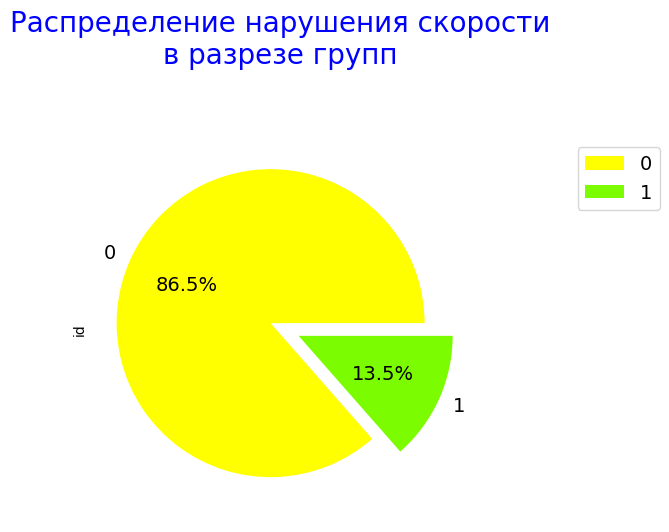

In [ ]:
# Построим груговую диаграмму и увидим доли клиентов в группах
exp = (0.1,0.1)
speed.groupby('speed_violations').agg({'id':'count'})\
            .plot(kind='pie',figsize=(5,5),colors = ['yellow','LawnGreen','DeepPink','DodgerBlue'], \
              autopct='%1.1f%%',fontsize=14, explode=exp, subplots=True)
plt.title('Распределение нарушения скорости \nв разрезе групп \n\n', fontsize=20, color = "b")
plt.legend(fontsize=14, bbox_to_anchor=(1.5, 1))
plt.xticks(rotation=0, fontsize=12, color = "b")
plt.yticks(rotation=0, fontsize=12, color = "b")

plt.show()

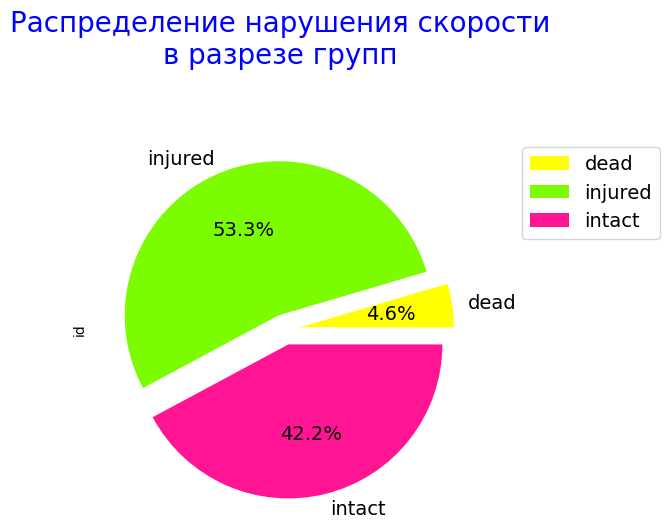

In [ ]:
# Построим круговую диаграмму, отражающую распределение степени тяжести вреда здоровью пешехода
exp = (0.1,0.1, 0.1)
speed_for_pie.groupby('health_status').agg({'id':'count'})\
            .plot(kind='pie',figsize=(5,5),colors = ['yellow','LawnGreen','DeepPink','DodgerBlue'], \
              autopct='%1.1f%%',fontsize=14, explode=exp, subplots=True)
plt.title('Распределение нарушения скорости \nв разрезе групп \n\n', fontsize=20, color = "b")
plt.legend(fontsize=14, bbox_to_anchor=(1.5, 1))
plt.xticks(rotation=0, fontsize=12, color = "b")
plt.yticks(rotation=0, fontsize=12, color = "b")

plt.show()

- В 13.5% случаев ДТП одной из причин стало несоблюдение скоростного режима. Это не означает, что это послужило причиной ДТП, Вполне возможно, что и другие участники ДТП также допустили нарушение, а также, что нарушение скорости было единственным нарушением.
- В случае с несоблюдением скорости ДТП приводит к 4.6% смертельшых случаев из всех участников ДТП. 53.3% участников получают травмы, а 42.3% не получают ущерба жизни и здоровью.

### Найдем зависимость между нарушением скоростного режима и сметрностью в ДТП

In [ ]:
speed.columns

Index(['id', 'speed_violations', 'dead_count', 'injured_count',
       'intact_count'],
      dtype='object')

In [ ]:
# Посмотрим связь между нарушением скорости и гибелью людей.
# Для непараметрического ряда рассчиаем ранговую корреляцию Спирмена
speed[['speed_violations','dead_count']].corr(method= 'spearman')

,speed_violations,dead_count
speed_violations,1.0,0.05587
dead_count,0.05587,1.0


Чтобы проверить, является ли эта корреляция статистически значимой, мы можем рассчитать p-значение, связанное с коэффициентом корреляции Спирмена, с помощью Scipy spearmanr(), которая возвращает коэффициент корреляции Спирмена вместе с двусторонним p-значением.

In [ ]:
spearmanr(speed[['speed_violations','dead_count']])

SignificanceResult(statistic=0.055867631874405986, pvalue=0.0)

Коэффициент корреляции равен 0.056, а двустороннее значение p = 0.0. Поскольку это значение p меньше общепринятого значения уровня статистической значимости 0.05, то мы можем заключить, что существует статистически значимая корреляция между двумя переменными. Зависимость очень слабая и положительная, нарушение скоростного режима увеличивает вероятность гибели участников ДТП

Повторим расчет для пострадавших в ДТП

In [ ]:
# Посмотрим связь между нарушением скорости и получением травмы или ранения людей.
# Для непараметрического ряда рассчиаем ранговую корреляцию Спирмена

speed[['speed_violations','injured_count']].corr(method= 'spearman')

,speed_violations,injured_count
speed_violations,1.0,0.02927
injured_count,0.02927,1.0


Чтобы проверить, является ли эта корреляция статистически значимой, мы можем рассчитать p-значение, связанное с коэффициентом корреляции Спирмена, с помощью Scipy spearmanr(), которая возвращает коэффициент корреляции Спирмена вместе с двусторонним p-значением.

In [ ]:
spearmanr(speed[['speed_violations','injured_count']])

SignificanceResult(statistic=0.029265775147987425, pvalue=1.9951914175659884e-264)

Коэффициент корреляции равен 0.029, а двустороннее значение p стремится к нулю. Поскольку это значение p меньше общепринятого значения уровня статистической значимости 0.05, то мы можем заключить, что существует статистически значимая корреляция между двумя переменными. Зависимость очень слабая и положительная, нарушение скоростного режима увеличивает вероятность получения последними травм и ранений.

### Проведем статистический тест

Создадим датасеты (выборки) нарушения скорости (1) и отсутствием нарушения  скорости (0)

In [ ]:
speed_violation = speed[speed['speed_violations'] == 1]

In [ ]:
speed_abidance = speed[speed['speed_violations'] == 0]

И посмотрим соотношение между погибшими в ДТП  для случаев соблюдения и не соблюдения скоростного режима

Посмотрим долю ДТП с погибшими.

#### Сформулируем нулевую гипотезу:
Среднее число НЕ погибших людей, в ДТП, где не нарушили ПДД не больше , чем среднее число НЕ погибших людей, в ДТП, где нарушили ПДД

In [ ]:
prepear_test(speed_violation, speed_abidance, 'dead_count', 'Нарушили', 'Не нарушили', "в ДТП с нарушением скорости")

Нарушили
    всего ДТП - 190574
    ДТП с dead_count - 25902
    ДТП без dead_count  - 164672
    Процент ДТП с dead_count 13.59%
Не нарушили
    всего ДТП - 1217879
    ДТП с dead_count - 107462
    ДТП без dead_count  - 1110417
    Процент ДТП с dead_count 8.82%
--------------------
Посчитаем статистику, проведем z-test

          пропорция успехов в первой группе p1 =  0.13591570728430952 
          пропорция успехов во второй группе p2 = 0.08823700876688079
          пропорция успехов в комбинированном датасете p_combined = 0.09468828565809438
          разница пропорций в датасетах difference =  0.04767869851742873
          z_value 66.10585266285347
p-значение:  0.0
Отвергаем нулевую гипотезу: доля c dead_count в ДТП с нарушением скорости больше, есть значимая разница
--------------------
Проведем t-test
p-значение:  0.0
Нулевая гипотеза отвергнута.  Для dead_count среднее значение распределения Нарушили выше, чем Не нарушили


#### Результат проверки гипотезы
Несмотря на то, сто метод Спирмана показал очень слабую зависимость между соблюдением скорости и числом погибших:
- Мы видим, что процент погибших в ДТП в случае, если они соблюдали скоростной режим, в полтора раза меньше, чем аналогичный показатель в случае, когда скоростной режим был нарушен.
- Проведенные тесты отвергают нулевую гипотезу о том, что Среднее число НЕ погибших людей, в ДТП, где не нарушили скоростной режим не больше , чем среднее число НЕ погибших людей, в ДТП, где нарушили скоростной режим. **То есть люди меньше(реже) погибает, если не нарушается скоростной режим**. или же люди больше (чаще) не погибают, если не нарушается скоростной режим


#### Проверим гипотезу с точки зрения получивших повреждения и ранения пешеходов   
Среднее число НЕ получивших повреждения людей, в ДТП, где не нарушили скоростной режим не больше , чем среднее число НЕ погибших людей, в ДТП, где нарушили скоростной режим

In [ ]:
 prepear_test(speed_violation, speed_abidance, 'injured_count', 'Нарушили', 'Не нарушили', "в ДТП с нарушением скорости")

Нарушили
    всего ДТП - 190574
    ДТП с injured_count - 174917
    ДТП без injured_count  - 15657
    Процент ДТП с injured_count 91.78%
Не нарушили
    всего ДТП - 1217879
    ДТП с injured_count - 1140935
    ДТП без injured_count  - 76944
    Процент ДТП с injured_count 93.68%
--------------------
Посчитаем статистику, проведем z-test

          пропорция успехов в первой группе p1 =  0.9178429376515159 
          пропорция успехов во второй группе p2 = 0.9368213098345566
          пропорция успехов в комбинированном датасете p_combined = 0.9342533971669627
          разница пропорций в датасетах difference =  -0.01897837218304066
          z_value -31.085128991305577
p-значение:  0.0
Отвергаем нулевую гипотезу: доля c injured_count в ДТП с нарушением скорости больше, есть значимая разница
--------------------
Проведем t-test
p-значение:  7.825690679446031e-182
Нулевая гипотеза отвергнута.  Для injured_count среднее значение распределения Нарушили выше, чем Не нарушили


#### Результат проверки гипотезы
- Мы видим, что процент получивших травмы в ДТП с нарушением скорости  несколько превышает аналогичный показатель в случае, когда в ДТП не было нарушения скорости.
- Проведенные тесты отвергают нулевую гипотезу о том, Среднее число НЕ получивших повреждения людей, в ДТП, где не нарушили скоростной режим не больше , чем среднее число НЕ погибших людей, в ДТП, где нарушили скоростной режим
 **То есть люди реже получают травмы, когда среди причин ДТП отсутствует превышение скорости**

# 4 Выводы и заключения по Части 2
В этой тетрадке мы произвели:
1. загрузку обработанных в Части 1 данных, сохранение в тетрадке необходимых и достаточных данных, удаление из тетрадки излишних данных
2. исследование распределения в разрезе годов и в разрезе сезонности:
 - количества происшествий,
 - количества погибших и пострадавших,
 - долей поибших и пострадавших относительно общего количетсва ДТП
3. сформировали и проверили гипотезы:
- В большинстве случаев виноваты пьяные водители, нужно усилить контроль:
  - количество ДТП с участием хотя бы одно водителя в состоянии опьянения происходят примерно в 9 раз реже, чем ДТП, где оба водителя трезвые. **Предположение, что в большинстве случаев виноваты пьяные водители не пнаходит подтверждения**
  - проверены и подтверждены гипотезы, что ДТП , в котором хотя бы один из участников находится в состоянии алкогольного опьянения, приводят к большему количеству погибших и к больг=шему количеству травмированных и раненых
- Безопасность на дорогах растет для каждого из участников:
 - Проведенные тесты отвергают гипотезы о том, что Среднее число погибших / пострадавших в ДТП в 2021-2023 годах не больше , чем среднее число погибших / пострадавших  в ДТП в 2018-2020 годах То есть люди в 2021-2023 годах погибают /получают травмы и ранения в ДТП НЕ РЕЖЕ, чем в 2018-2020 годах. Следовательно, безопасность на дорогах не растет, **проверяемая гипотеза не находит подтверждения**
- В личном автомобиле ехать безопаснее чем в автобусе:
 - Проведенные тесты отвергают нулевую гипотезу о том, что Среднее погибших в ДТП с автомобилями не больше , чем среднее погибших в ДТП с автобусами. Мы не можем подтвердить, что в автомобиле ехать безопаснее, чем в автобусе. **Проверяемая гипотеза не находит подтверждения**
- Если пешеходы не будут нарушать, то не будут гибнуть
 - Проведенные тесты отвергают гипотезу о том, что Среднее число НЕ погибших пешеходов, которые не нарушили ПДД не больше , чем среднее число НЕ погибших пешеходов, которые нарушили ПДД. То есть Пешеход меньше (реже) погибает, если не нарушает ПДД. Или же Пешеход больше (чаще) не погибает, если не нарушает ПДД. **Проверяемая гипотеза находит подтверждение**
- Низкая скорость не влияет на тяжесть ДТП
 - Проведенные тесты отвергают нулевую гипотезу о том, что Среднее число НЕ погибших людей, в ДТП, где не нарушили скоростной режим не больше , чем среднее число НЕ погибших людей, в ДТП, где нарушили скоростной режим. То есть люди меньше (реже) погибает, если не нарушается скоростной режим. Или же люди больше (чаще) не погибают, если не нарушается скоростной режим. **Проверяемая гипотеза находит подтверждение**





# 5 Рекомендации Заказчику.  
Есть наблюдение, что автомобили классифицируются некорректно.
Пример 1:
Одна и таже модель Тойоты – Карина – отнесена к разным классам автомобилей




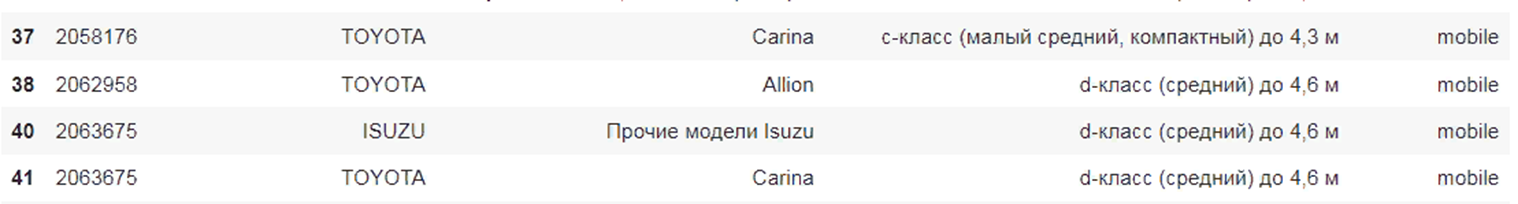

Пример 2:
Опель Астра является автомобилем с-класса, а отнесен в d-классу



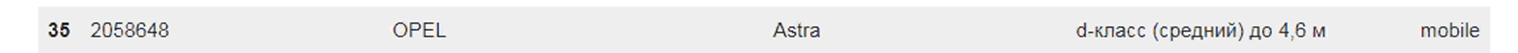

Также для классификации автобусов используются параллельно термины: «двухэтажный» и «двухярусный» и «одноэтажный» и «одноярусный».  

В списоке значений категорий участников отсутствуют водители и пассажиры, что дает нам основания предположить, что категория "Все участники" предполагает как раз категори "Водители и пассажиры".


**Рекомендации**:
- Целесообразно использовать встроенный обновляемый классификатор, который автоматически отнести бренд/модель легкового (и иного) автомобиля в соответствующую категорию.
- Целесообразно унифицировать классификацию автобусов в плане этажности
- Проверить корректность наименования и заполнения значений категорий участников  "Все участники".